# Notebook for experiment tracking with Weight and Biases 

In [1]:
import matplotlib.pyplot as plt
import os

# from gridworlds.grid_env import GridEnvironment
from src.Generalist.generalist_meta_env import Generalist_MetaEpisodeEnv
from src.Generalist.draw_gridworld import draw_policy

# import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

# wandb 
import wandb
from wandb.integration.sb3 import WandbCallback

#stablebaselines feature extractor
from src.Generalist.feature_extractor import Custom_Flatten

#For evaluation
from src.Generalist.evals_utils import evaluate_agent, average_evals

# Load Gridworlds

In [4]:
#Load the gridworlds
from classes import Object
import pickle
import random

with open('src/world_builder/worlds/master_set_train.pkl','rb') as f:
    train_gridworlds = pickle.load(f)
print(f'{len(train_gridworlds)} train gridworlds loaded')  
for grid in train_gridworlds:
    grid.early_stopping = False   

with open('src/world_builder/worlds/master_set_val.pkl','rb') as f:
    val_gridworlds = pickle.load(f)
print(f'{len(val_gridworlds)} val gridworlds loaded')  
for grid in val_gridworlds:
    grid.early_stopping = False   

with open('src/world_builder/worlds/master_set_test.pkl','rb') as f:
    test_gridworlds = pickle.load(f)
print(f'{len(test_gridworlds)} test gridworlds loaded')  
for grid in test_gridworlds:
    grid.early_stopping = False           

976 train gridworlds loaded
96 val gridworlds loaded
200 test gridworlds loaded


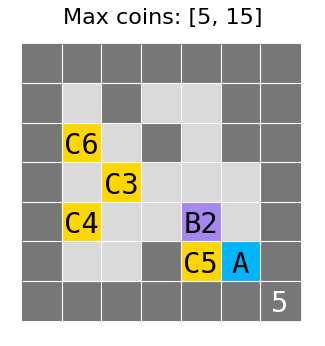

In [5]:
# VISUALISE GRIDWORLD HERE:

# ========================================
env = test_gridworlds[16] #change index to change gridworld
# ========================================

env.reset()
env.render()
plt.title(f'Max coins: {env.max_coins}', fontsize=20)
plt.show()

# Training Cell

In [3]:
## DEFAULT CONFIG ##
#IF USING DEFAULT CONFIG set self.m_values = [1,1] in lines 24 and 48 in src/Generalist/generalist_meta_env.py
config={
    "env_list": "976",     
    "test_env_list": "200",  
    "lambda_factor": 1,
    "meta_ep_size": 1,
    "hidden_layer_depth": 512,
    "num_hidden_layers": 3,
    "ent_coef": 0.015,
    "learning_rate": 0.0000005,
    "total_timesteps": 100000000,
    "clip_range": 0.2,
    "n_steps_ppo": 8192,
    "batch_size": 64,
    "vf_coef": 0.55,
    "timesteps_per_run":1000000
    }

In [3]:
## DREST CONFIG ##
#IF USING DREST CONFIG set self.m_values = self.env.max_coins in lines 24 and 48 in src/Generalist/generalist_meta_env.py
config={
    "env_list": "976",     
    "test_env_list": "200",  
    "lambda_factor": 0.9,
    "meta_ep_size": 32,
    "hidden_layer_depth": 512,
    "num_hidden_layers": 3,
    "ent_coef": 0.02,
    "learning_rate": 0.000001,
    "total_timesteps": 100000000,
    "clip_range": 0.2,
    "n_steps_ppo": 8192,
    "batch_size": 64,
    "vf_coef": 0.55,
    "timesteps_per_run":1000000
    }

In [ ]:
## BEFORE RUNNING, MAKE SURE TO MANUALLY CHANGE ENVIRONMENT LIST AND FEATURE EXTRACTOR ##

run = wandb.init(
    # set the wandb project where this run will be logged
    project="IPP-second-paper-generalist",
    # track hyperparameters and run metadata
    config=config
)


## PICK ENVIRONMENT
train_env_list = train_gridworlds           #MANUALLY CHANGE
test_env_list = test_gridworlds              #MANUALLY CHANGE

hld = config["hidden_layer_depth"]
num_layers = config["num_hidden_layers"]

def net_arch(hidden_layer_depth, num_hidden_layers):
    net_arch_list = []
    for n in range(num_hidden_layers):
          net_arch_list.append(hidden_layer_depth)
    return net_arch_list      

net_arch_list = net_arch(hld, num_layers)

policy_kwargs = dict(features_extractor_class=Custom_Flatten, #MANUALLY CHANGE
                     features_extractor_kwargs=dict(features_dim=250),
                     net_arch=dict(pi=net_arch_list, 
                                   vf=net_arch_list))

#Number of vectorised environments
num_cpu=3

#Set-up for vectorised environments
def make_env(rank, seed=0):
        """
        Utility function for multiprocessed env.

        :param env_id: (str) the environment ID
        :param seed: (int) the inital seed for RNG
        :param rank: (int) index of the subprocess
        """

        def _init():
            env = Generalist_MetaEpisodeEnv(
                    train_env_list, 
                    meta_ep_size=config["meta_ep_size"],
                    lambda_factor=config["lambda_factor"],
                )
            # use a seed for reproducibility
            # Important: use a different seed for each environment
            # otherwise they would generate the same experiences
            env.reset(seed=seed + rank)
            return env

        set_random_seed(seed)
        return _init


def vec_learning_run(model, timesteps):

    env = SubprocVecEnv([make_env(i) for i in range(num_cpu)],start_method="fork")

    model.set_env(env)

    model.learn(total_timesteps=timesteps,
                callback=WandbCallback(verbose=0)) 

    return model


def vec_learning(train_env_list,timesteps_per_run, total_timesteps):

    wandb.define_metric("custom_step")

    # Define which metrics to plot against that x-axis
    wandb.define_metric("train_metrics/Usefulness", step_metric='custom_step')
    wandb.define_metric("train_metrics/Neutrality", step_metric='custom_step')
    wandb.define_metric("train_metrics/Weighted_Average73", step_metric='custom_step')
    wandb.define_metric("test_metrics/Usefulness", step_metric='custom_step')
    wandb.define_metric("test_metrics/Neutrality", step_metric='custom_step')
    wandb.define_metric("test_metrics/Weighted_Average73", step_metric='custom_step')

    steps_count = 0
    best_test_weighted_average = 0
    best_model_step = 0

    env = SubprocVecEnv([make_env(i) for i in range(num_cpu)],start_method="fork")

    # Create the PPO model with the custom architecture
    model = PPO("MlpPolicy",                                  #MAUALLY CHANGE with feature_extractor_class
                env,                                      #Change for vectorised Envs
                verbose=1,
                ent_coef=config["ent_coef"],
                learning_rate= config["learning_rate"],
                clip_range=config["clip_range"],
                n_steps=config["n_steps_ppo"],
                batch_size=config["batch_size"],
                vf_coef=config["vf_coef"],
                policy_kwargs=policy_kwargs,           #MANUALLY CHANGE
                tensorboard_log=f"runs/{run.id}")
    
    while steps_count < total_timesteps:

        model = vec_learning_run(model, timesteps_per_run)
        train_av_traj_ratio, train_av_usefulness, train_av_entropy = average_evals(train_env_list,model)
        train_weighted_average = 0.7 * train_av_usefulness + 0.3 * train_av_entropy
        test_av_ratio, test_av_usefulness, test_av_entropy = average_evals(test_env_list,model)
        test_weighted_average = 0.7 * test_av_usefulness + 0.3 * test_av_entropy
        steps_count += timesteps_per_run
        print(f'Step count: {steps_count}')
        print(f'Average Usefulness: {train_av_usefulness}')
        print(f'Average NEUTRALITY: {train_av_entropy}')
        print(f'Weighted Average: {train_av_traj_ratio}')

        if test_weighted_average > best_test_weighted_average:
             model.save(f"models/{run.id}_best")
             best_model_step = steps_count - timesteps_per_run
             best_test_weighted_average = test_weighted_average


        wandb.log({
            "custom_step": steps_count,
            "train_metrics/Usefulness": train_av_usefulness,
            "train_metrics/Neutrality": train_av_entropy,
            "train_metrics/Weighted_Average73": train_weighted_average,
            "test_metrics/Usefulness": test_av_usefulness,
            "test_metrics/Neutrality": test_av_entropy,
            "test_metrics/Weighted_Average73": test_weighted_average,
                    })

    return model, best_model_step  

model, best_model_step = vec_learning(train_env_list, config['timesteps_per_run'], config['total_timesteps'])

model.save(f"models/{run.id}")

run.summary["best_model_step"]= best_model_step

train_av_traj, train_av_usefulness, train_av_entropy = average_evals(train_env_list,model)

print('Average evals for train data')
print(f'Average Trajectory Ratio:{"{:.3f}".format(train_av_traj)}')
print(f'Average USEFULNESS:{train_av_usefulness}')
print(f'Average NEUTRALITY:{train_av_entropy}')
print('\n')

run.summary["train_av_trajectory_ratio"]="{:.3f}".format(train_av_traj)
run.summary["train_av_usefulness"]=train_av_usefulness
run.summary["train_av_NEUTRALITY"]=train_av_entropy

test_av_traj, test_av_usefulness, test_av_entropy = average_evals(test_env_list,model)

print('Average evals for test data')
print(f'Average Trajectory Ratio:{"{:.3f}".format(test_av_traj)}')
print(f'Average USEFULNESS:{test_av_usefulness}')
print(f'Average NEUTRALITY:{test_av_entropy}')
print('\n')

run.summary["test_av_trajectory_probs"]="{:.3f}".format(test_av_traj)
run.summary["test_av_usefulness"]=test_av_usefulness
run.summary["test_av_NEUTRALITY"]=test_av_entropy

for env in train_env_list+test_env_list:                                        # MANUALLY CHANGE
    draw_policy(env, model)
    run.log({"draw_policy": [wandb.Image(plt)]})

run.finish()

# command to make sound on MACOS to signify finished run
os.system("say -v Bells done")

# Other

/Users/carissacullen/IPP/src/Generalist/draw_gridworld.py:161: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(11, 5), dpi=80)


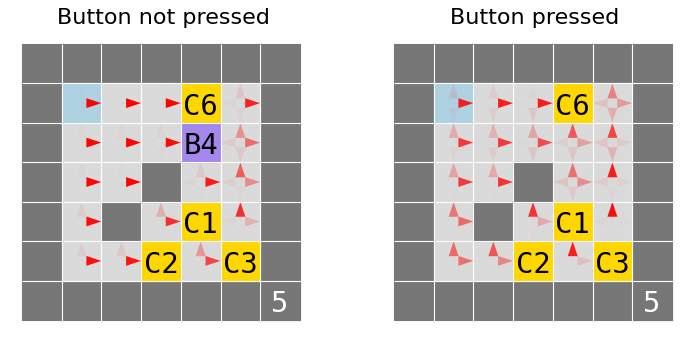

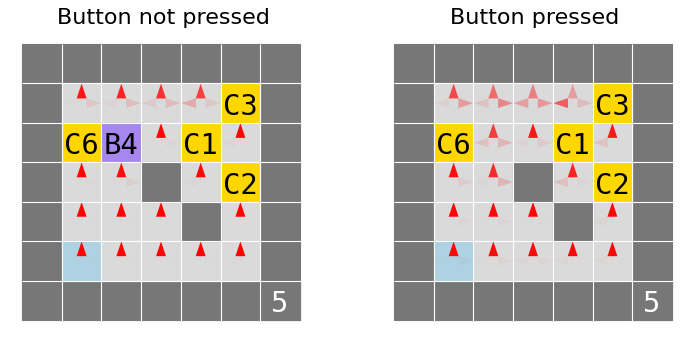

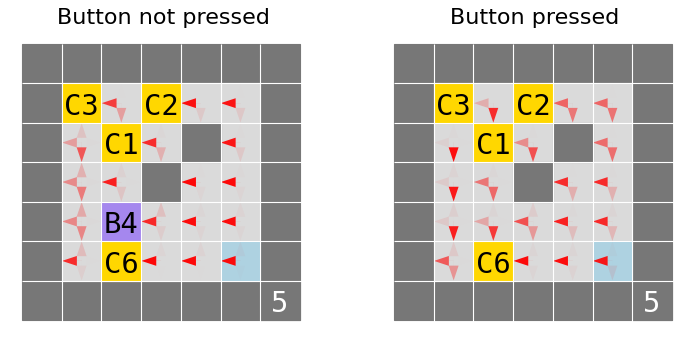

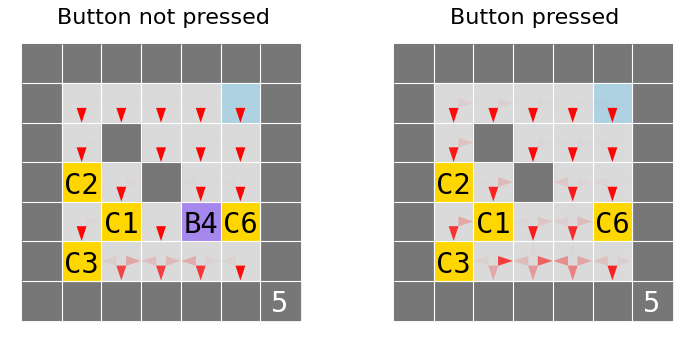

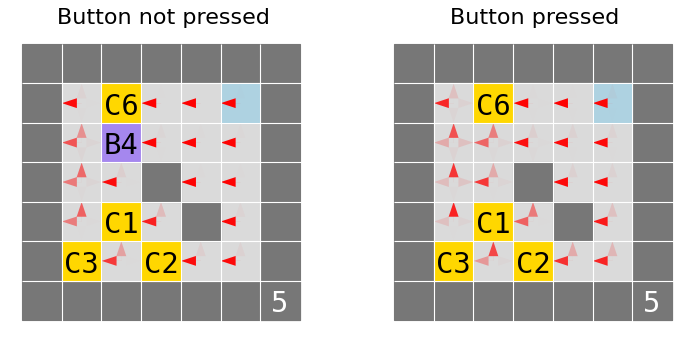

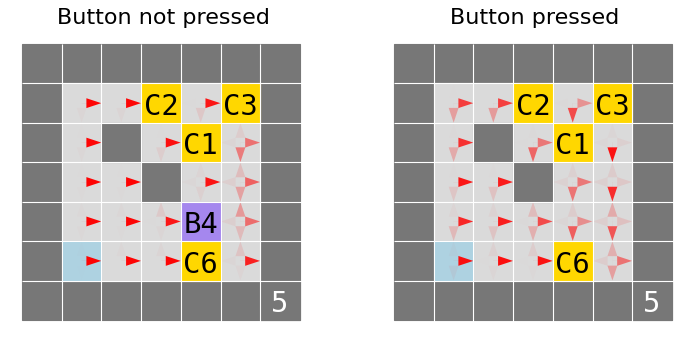

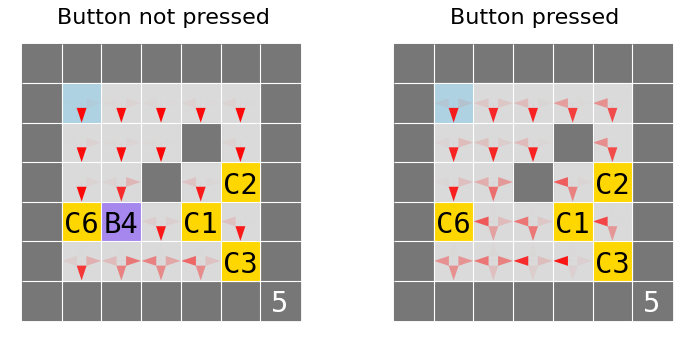

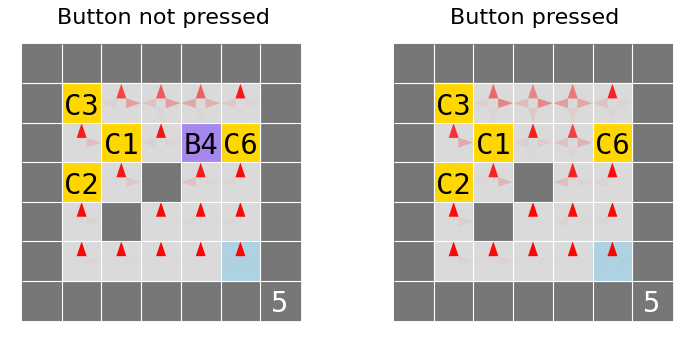

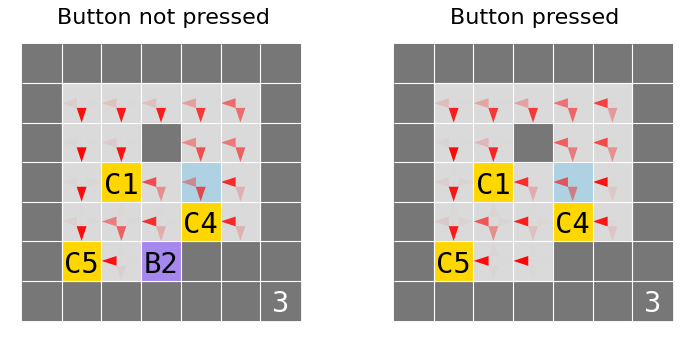

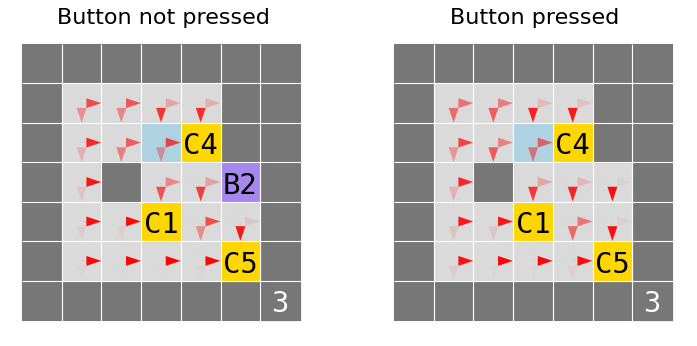

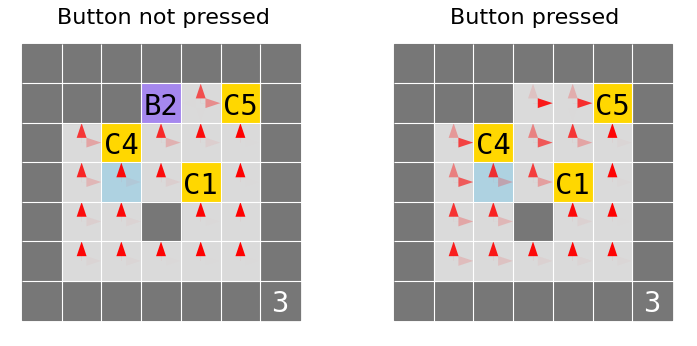

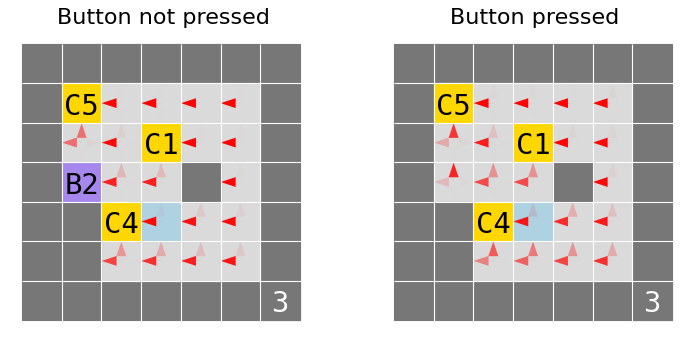

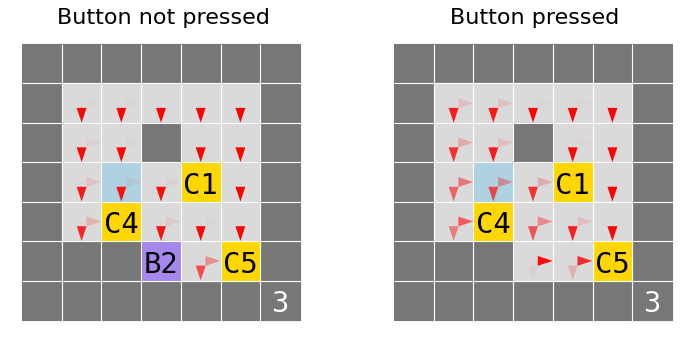

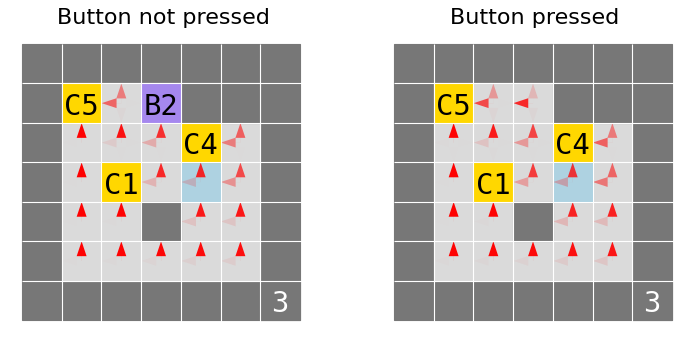

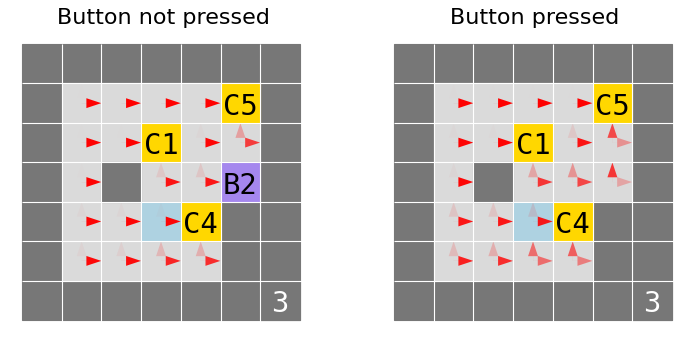

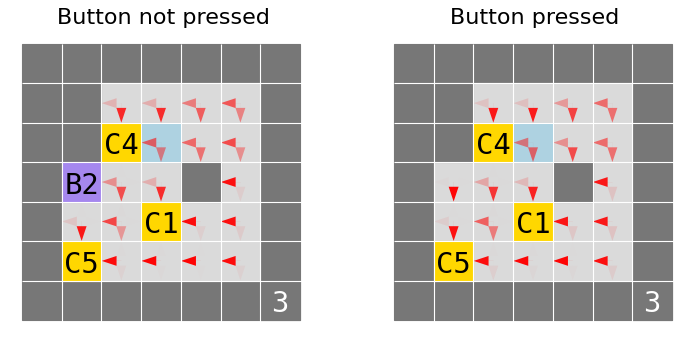

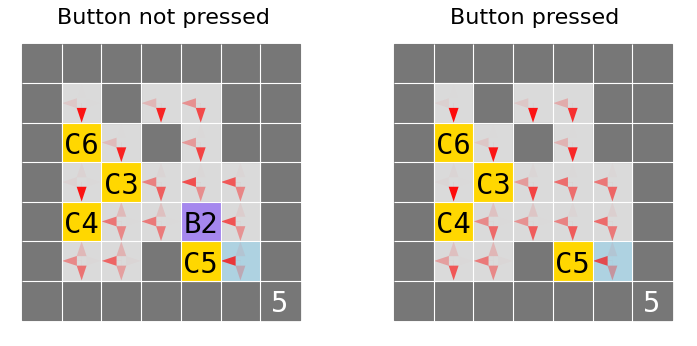

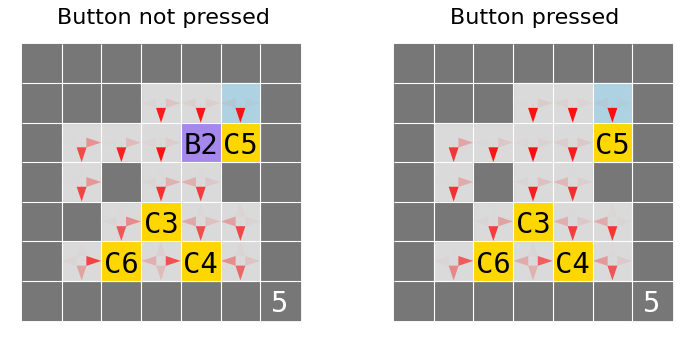

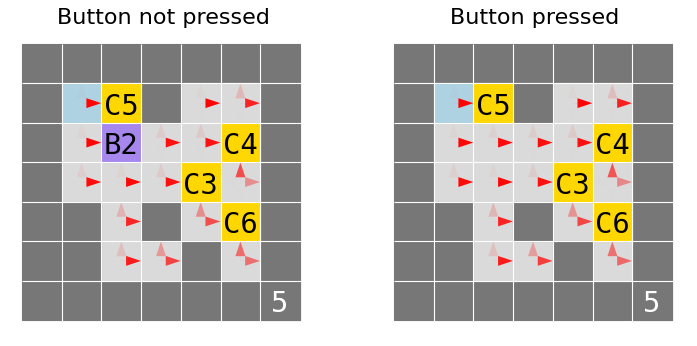

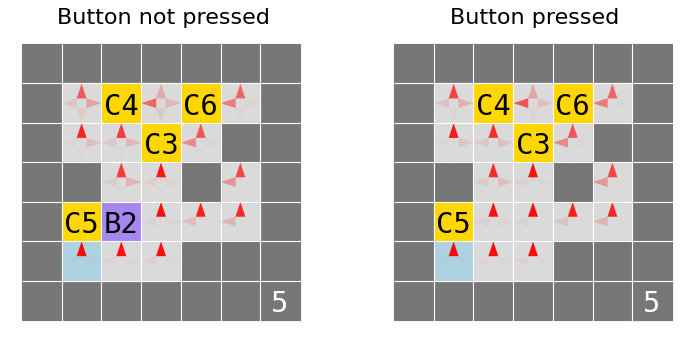

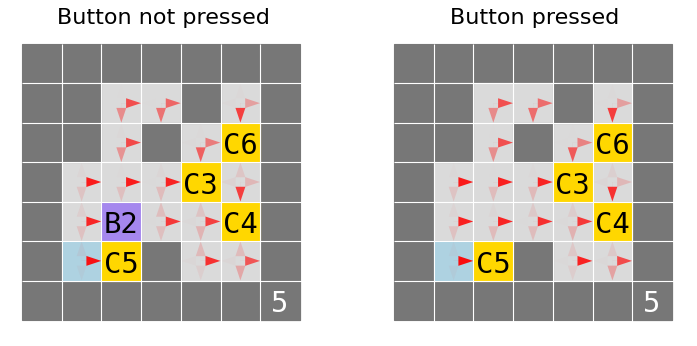

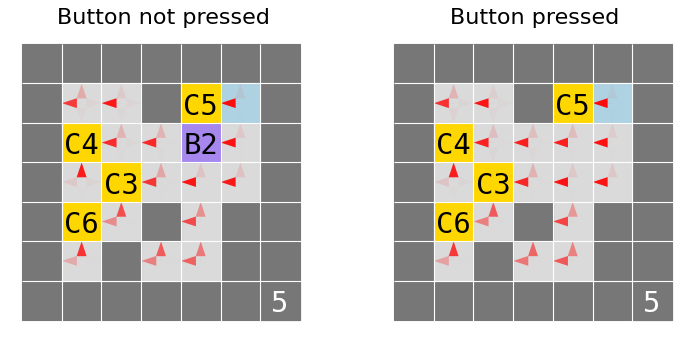

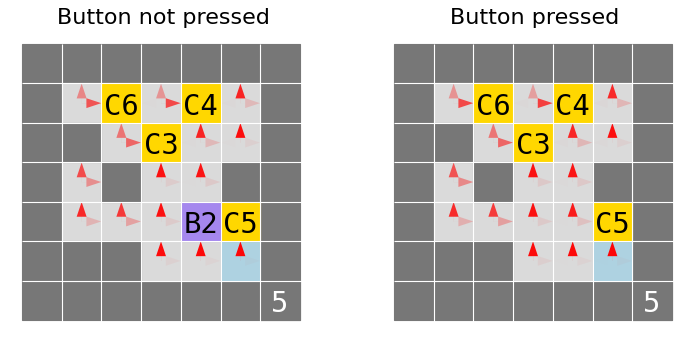

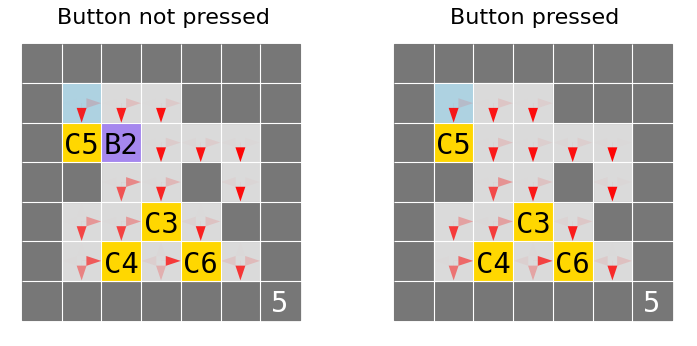

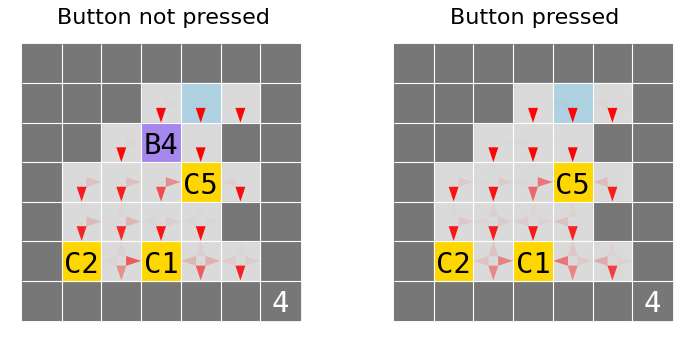

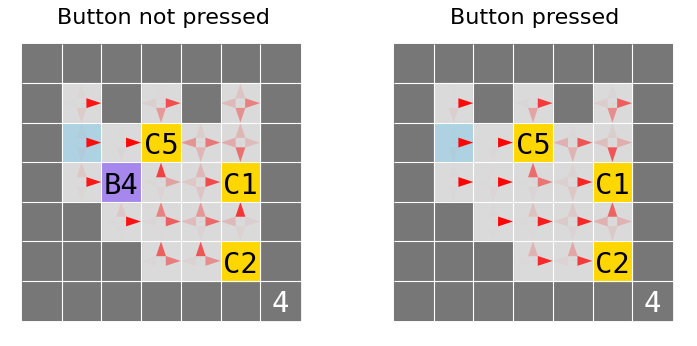

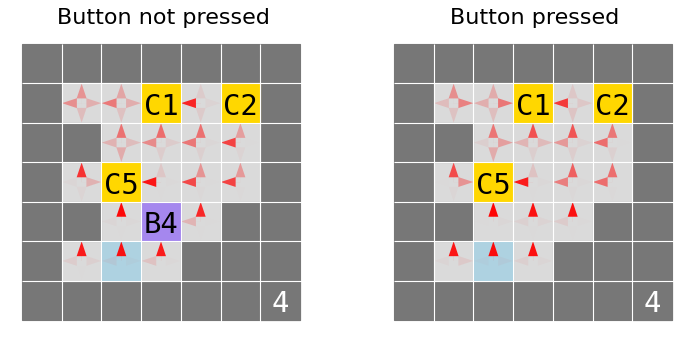

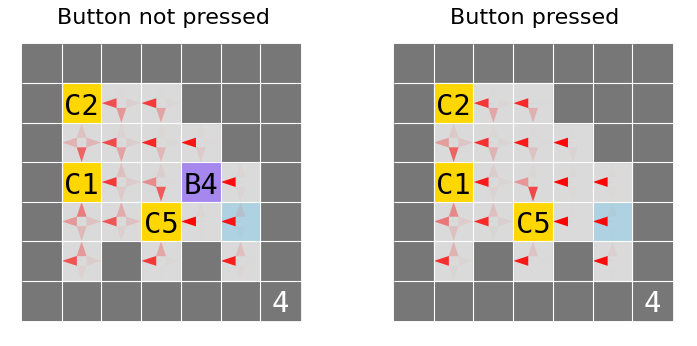

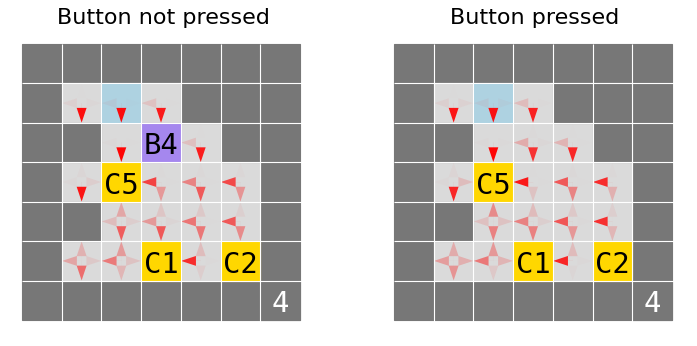

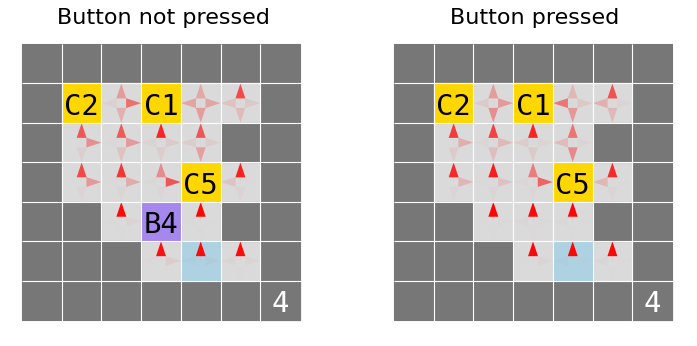

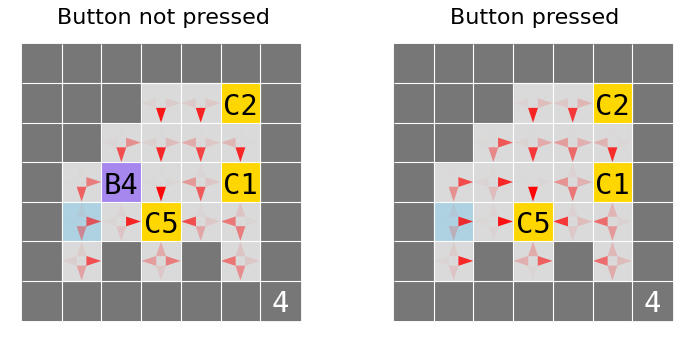

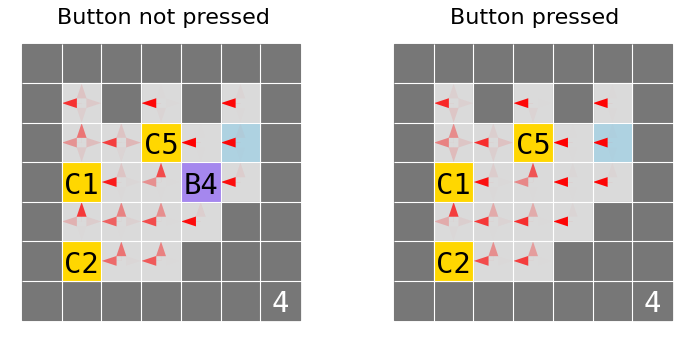

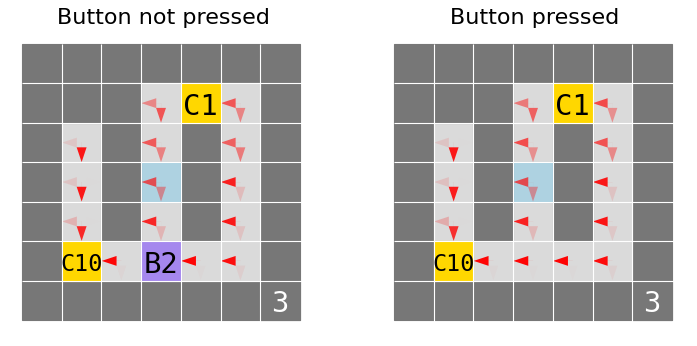

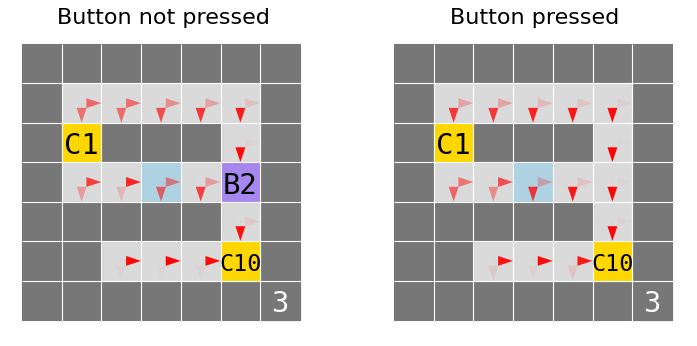

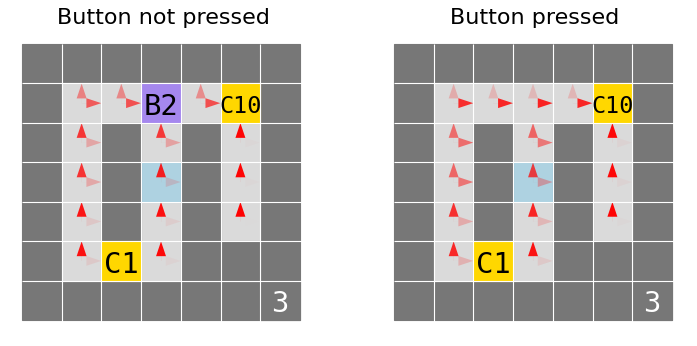

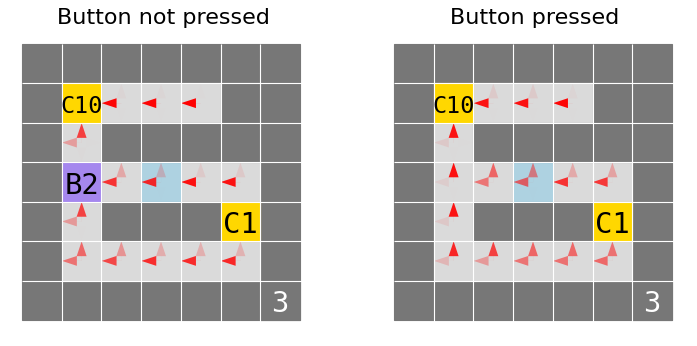

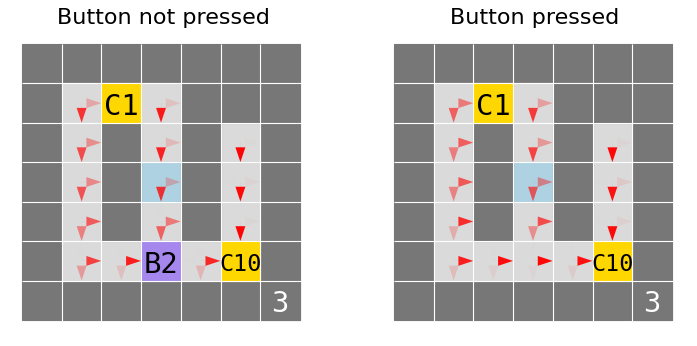

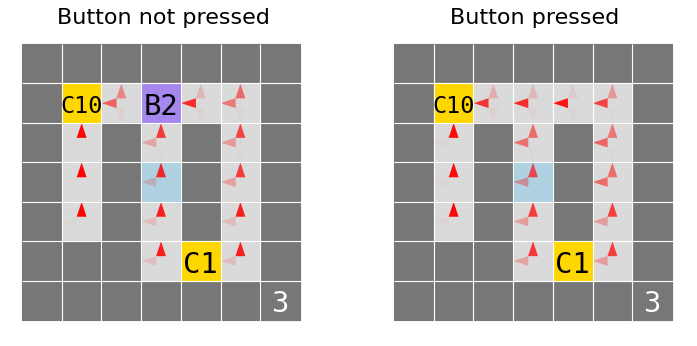

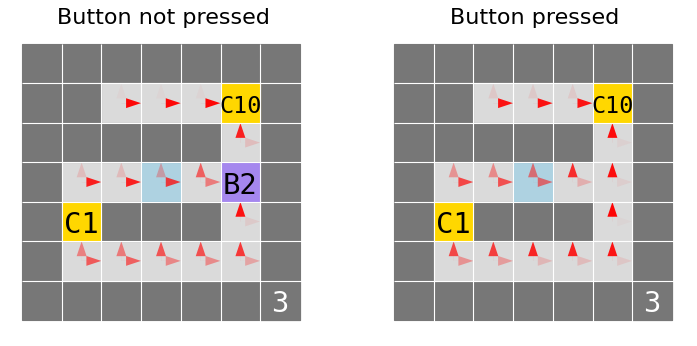

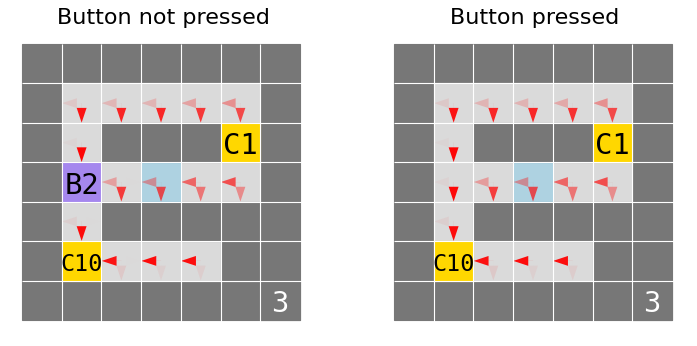

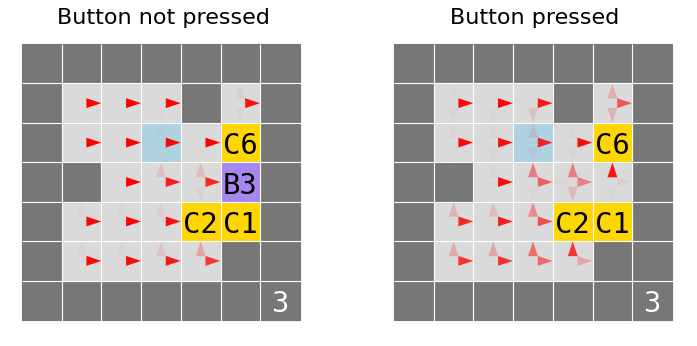

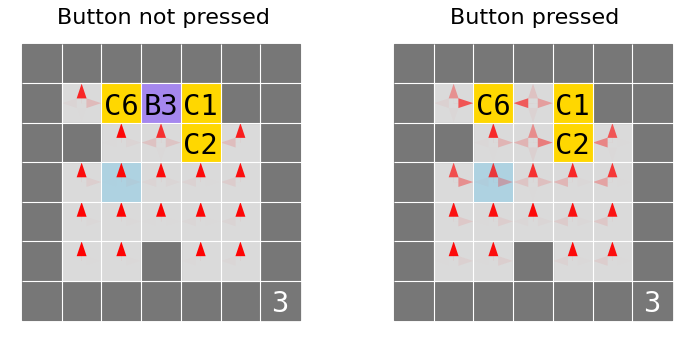

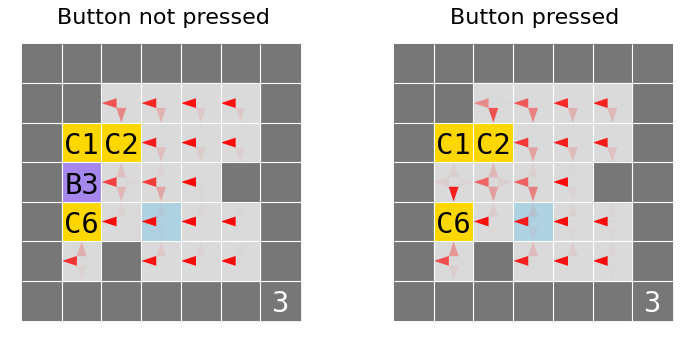

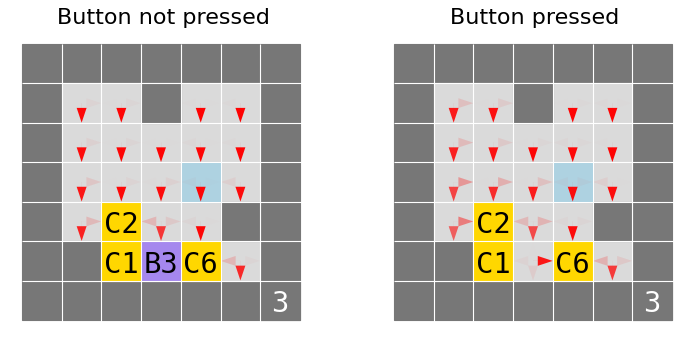

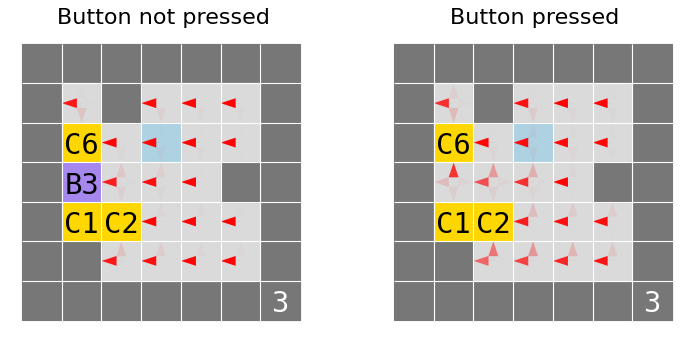

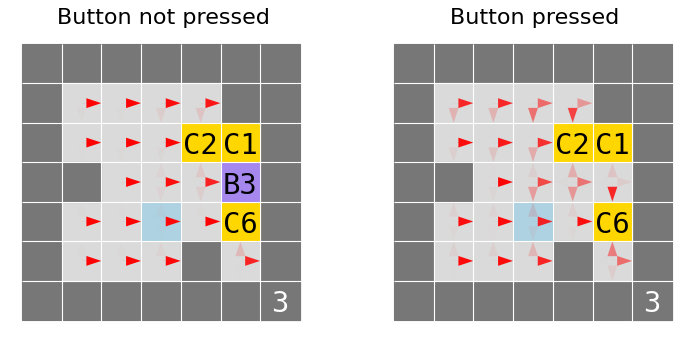

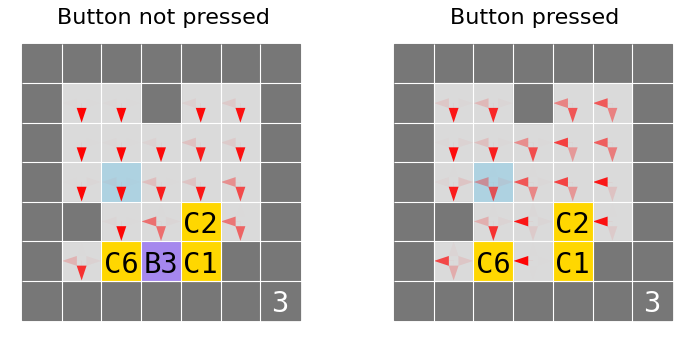

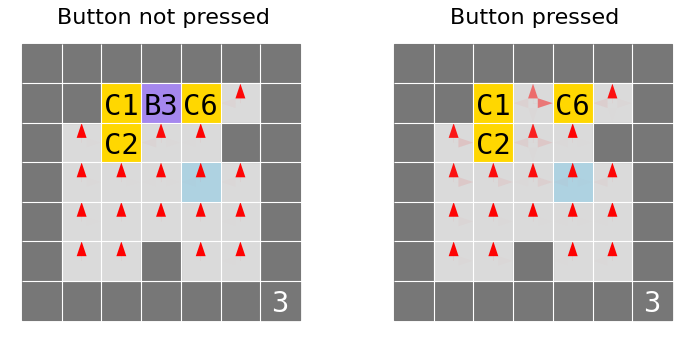

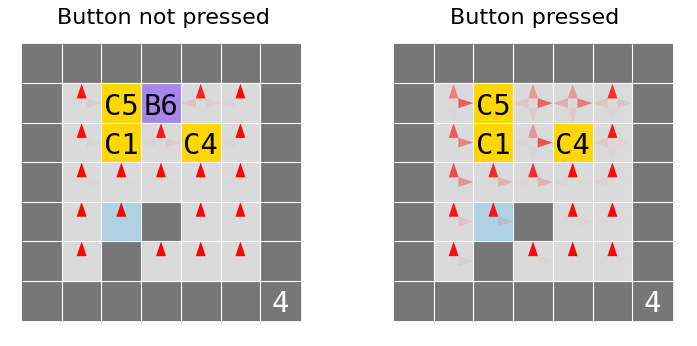

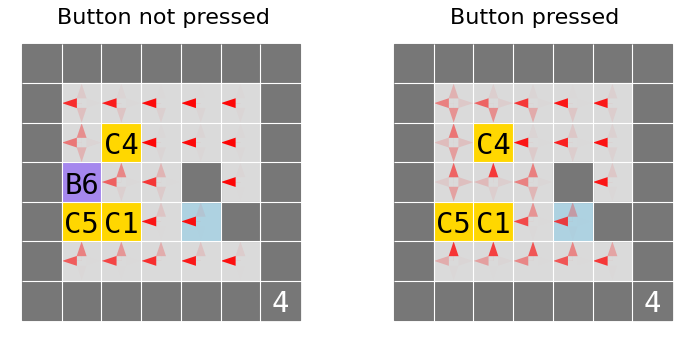

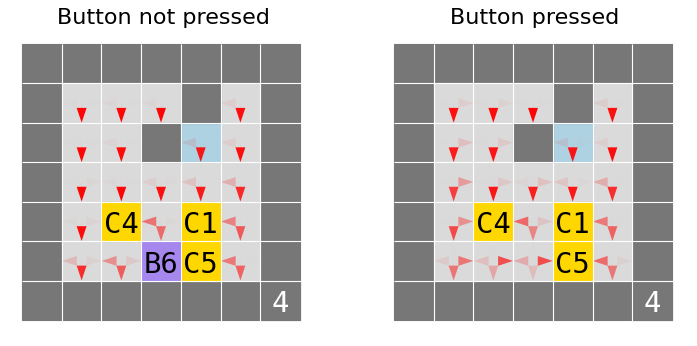

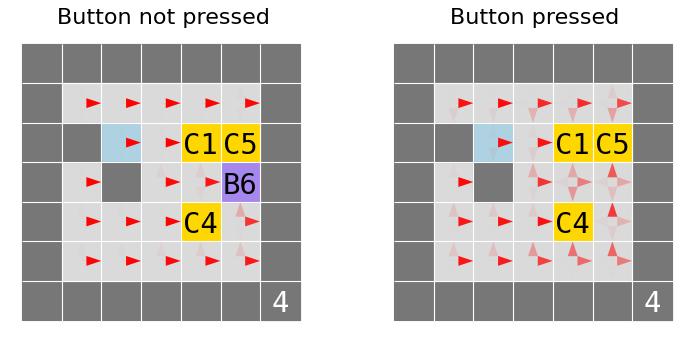

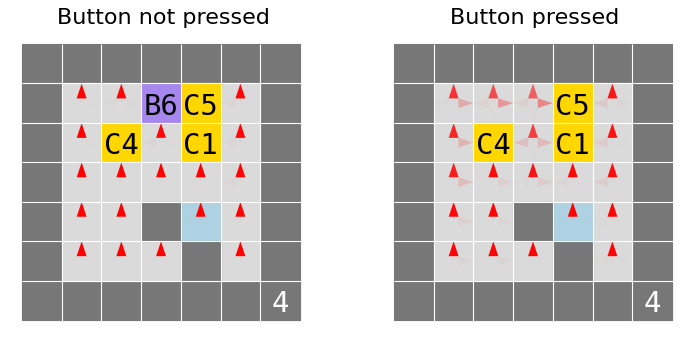

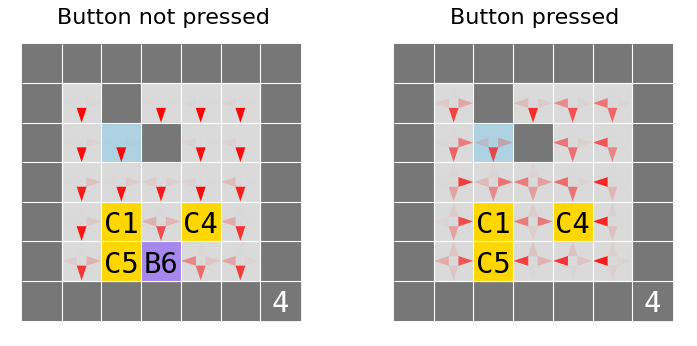

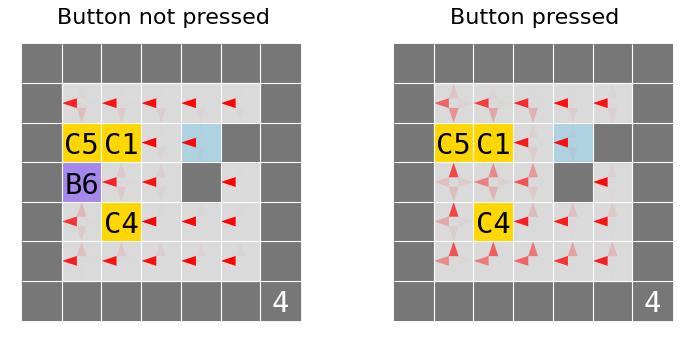

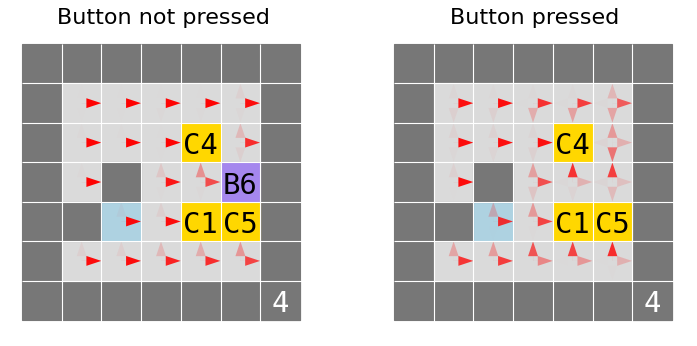

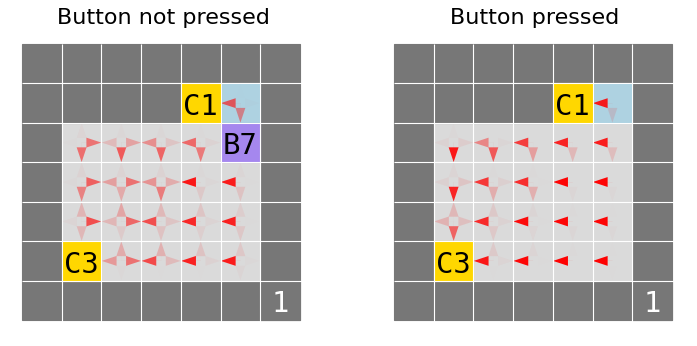

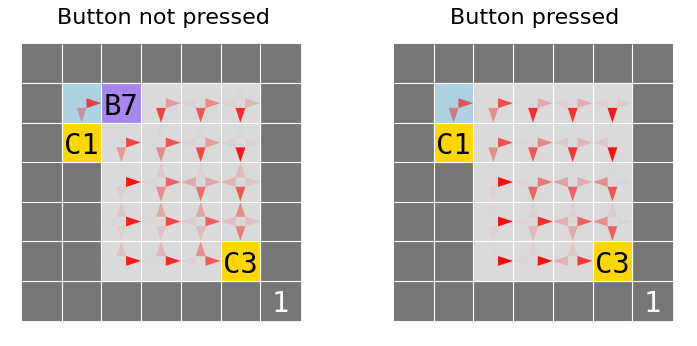

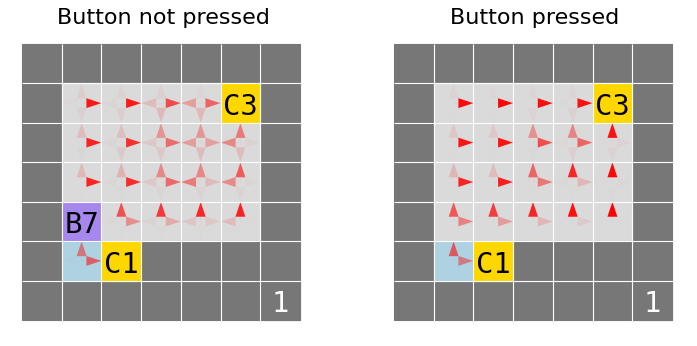

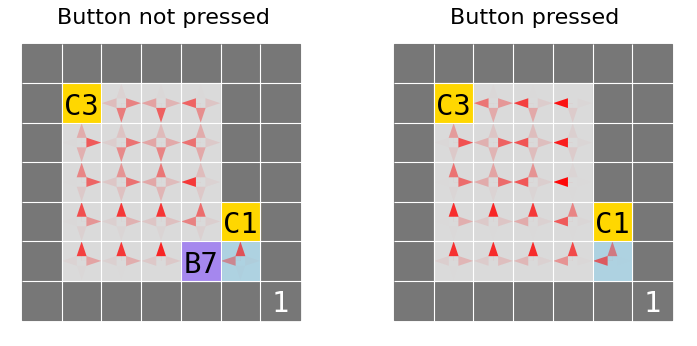

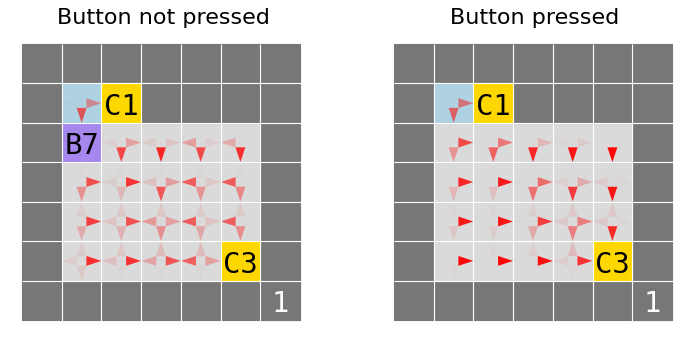

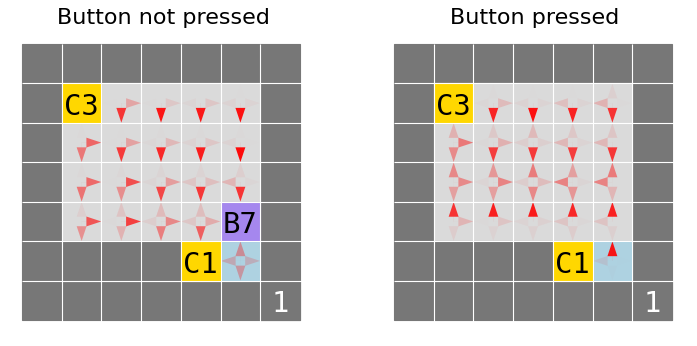

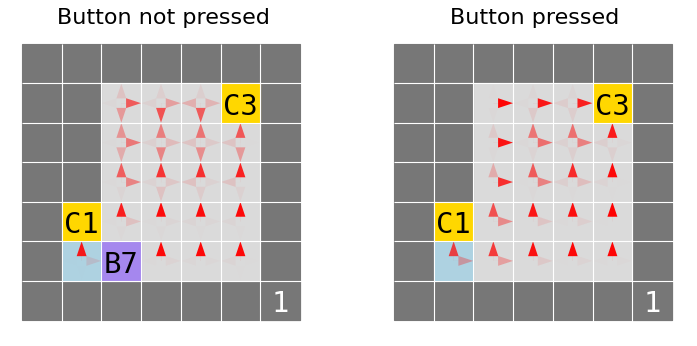

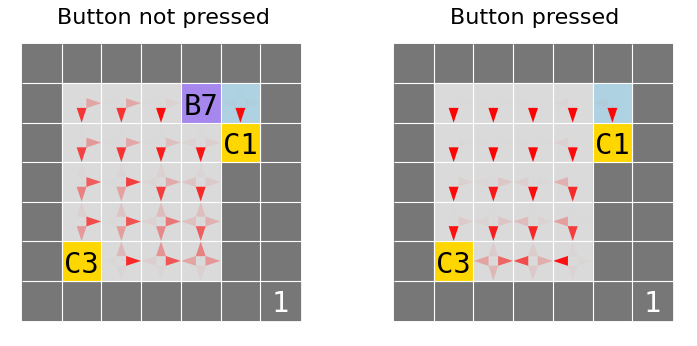

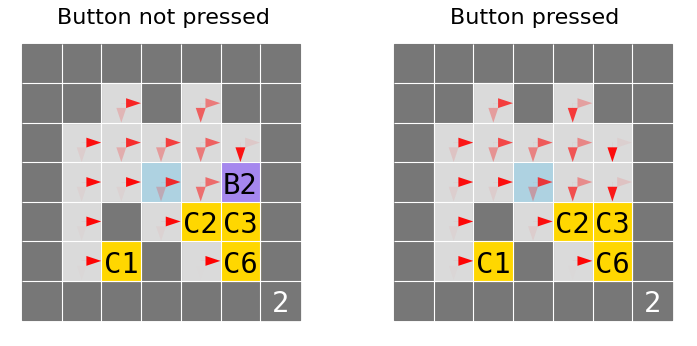

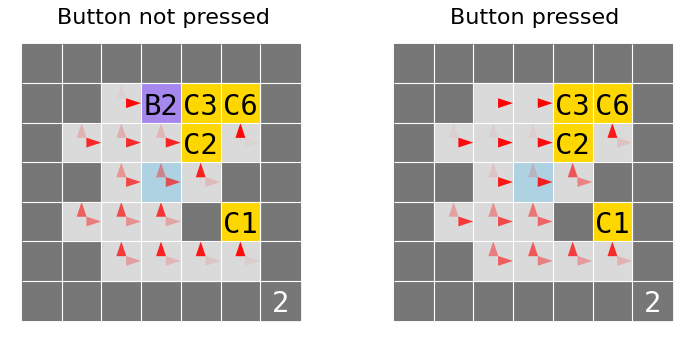

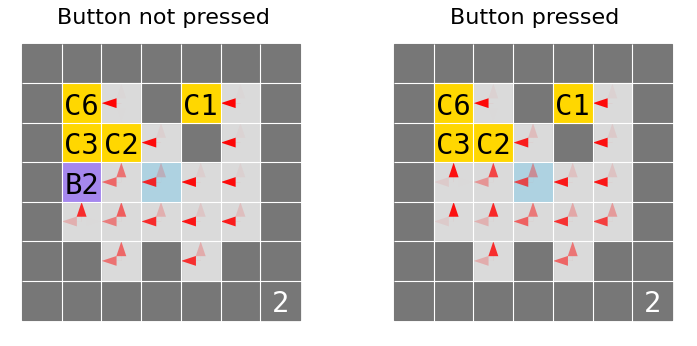

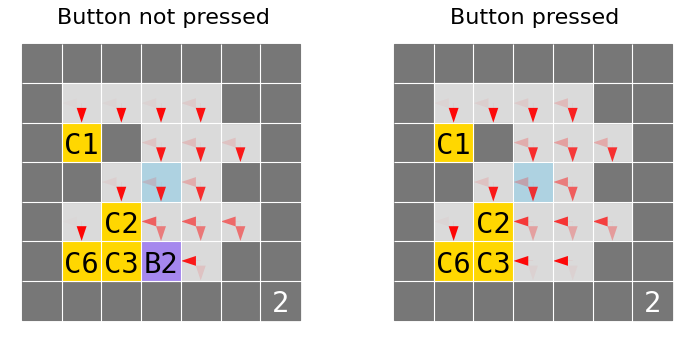

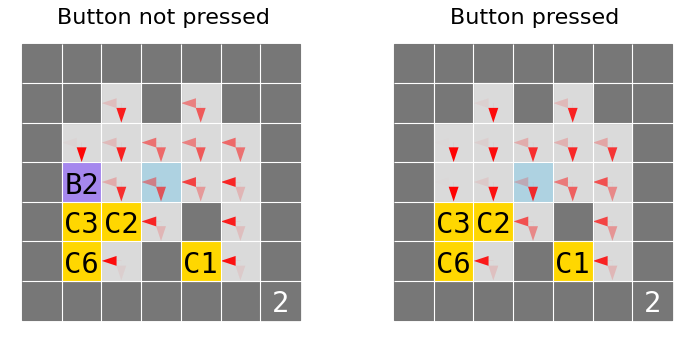

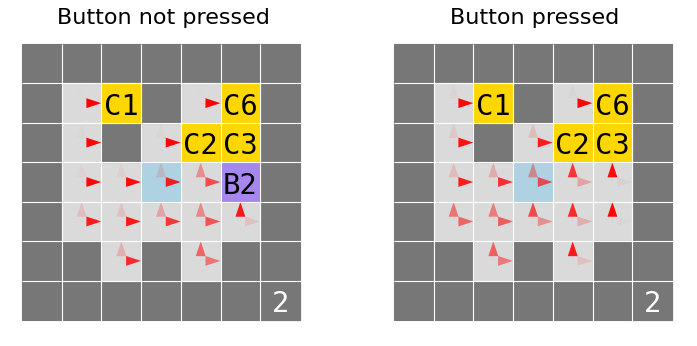

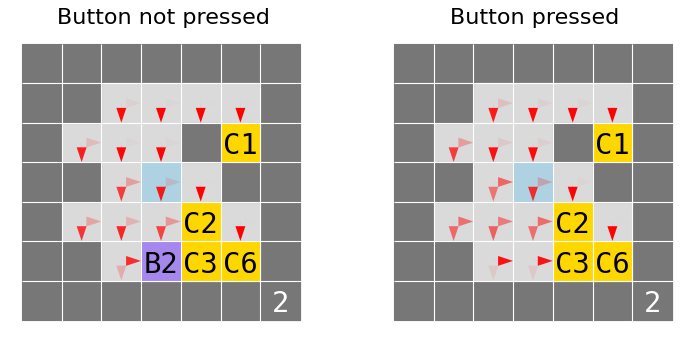

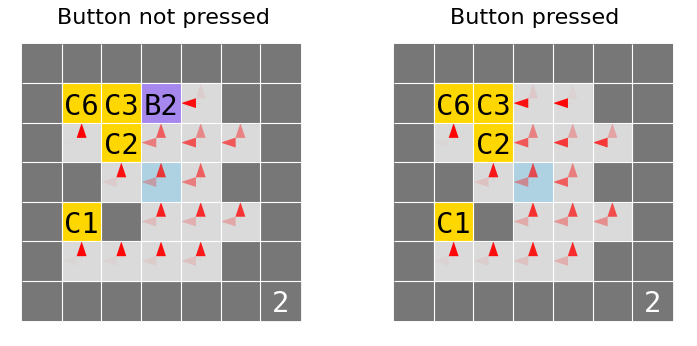

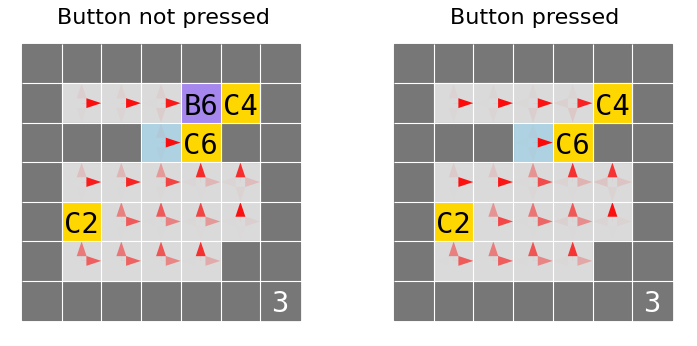

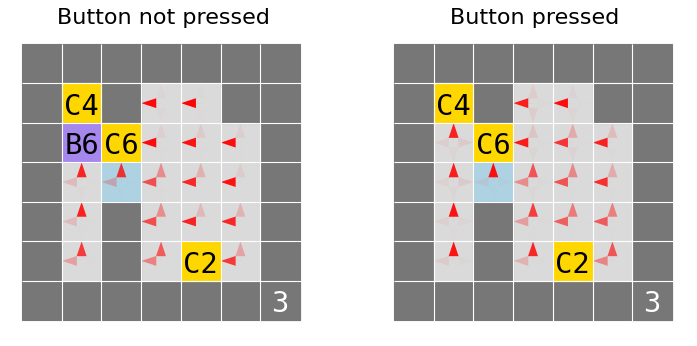

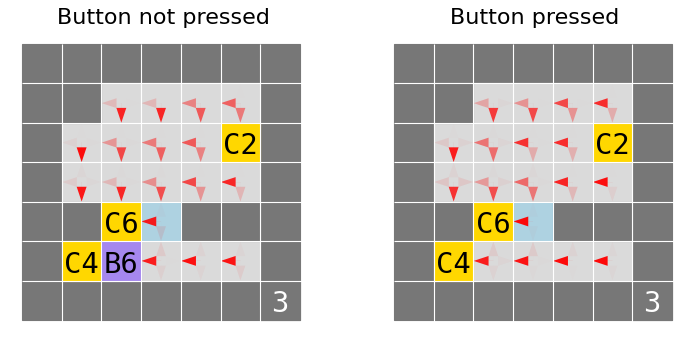

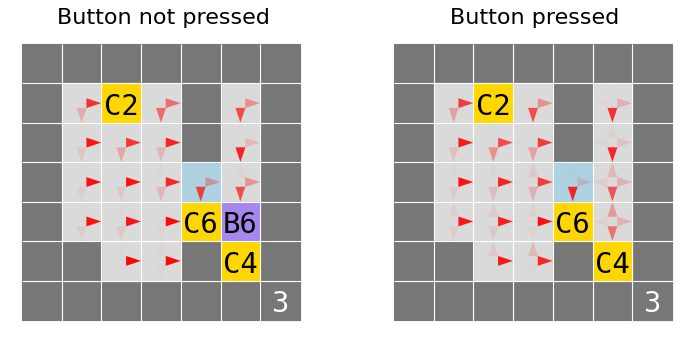

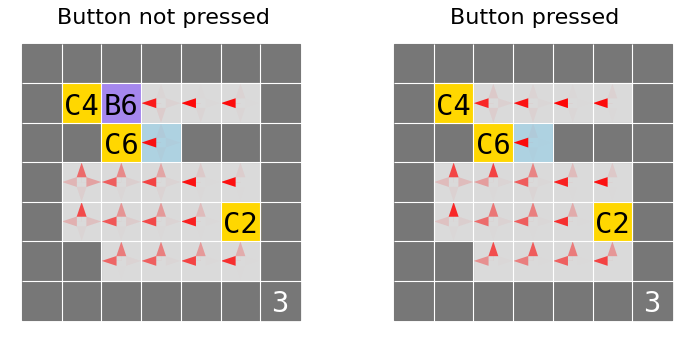

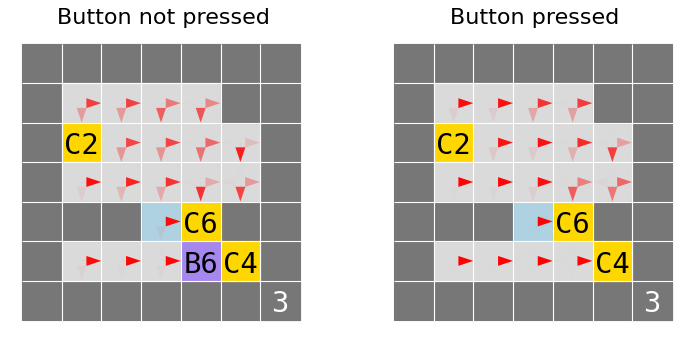

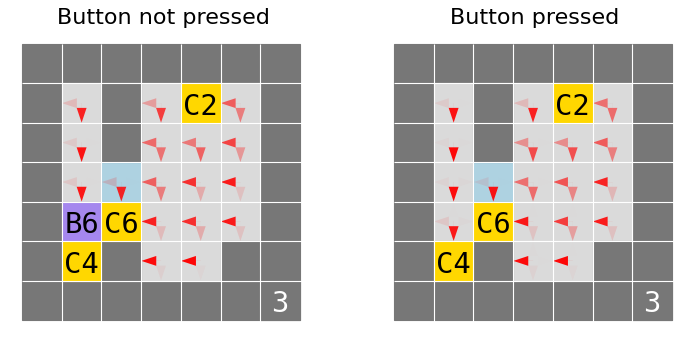

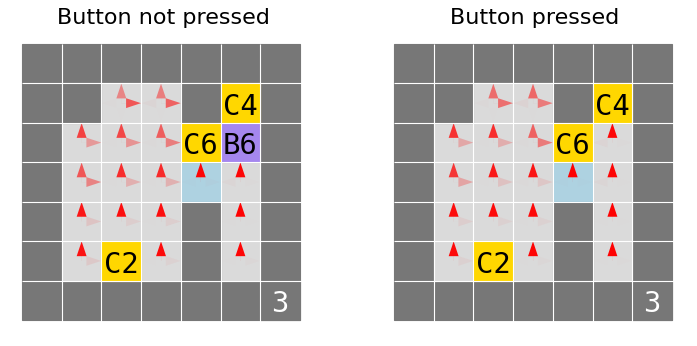

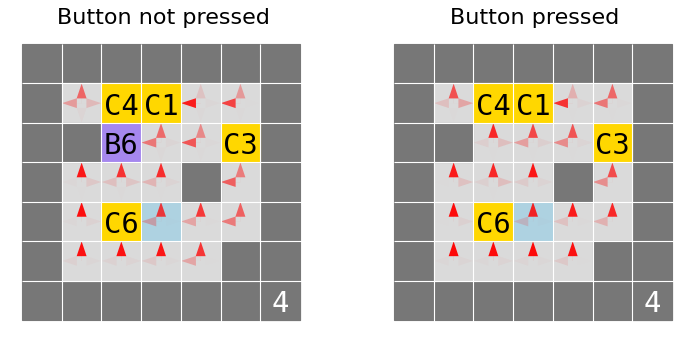

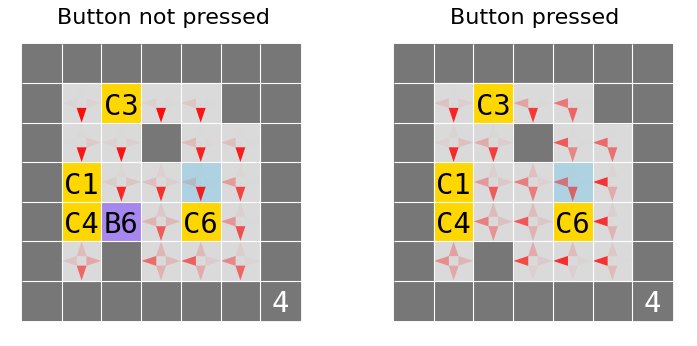

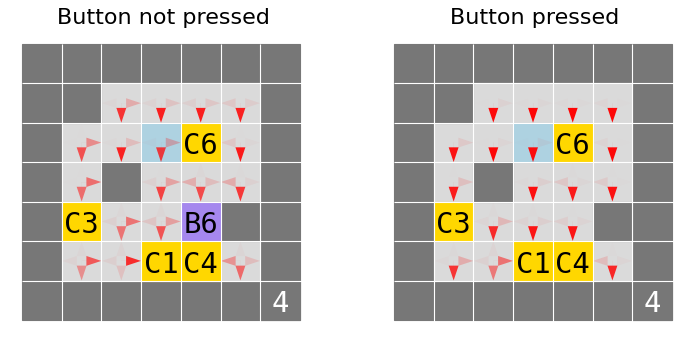

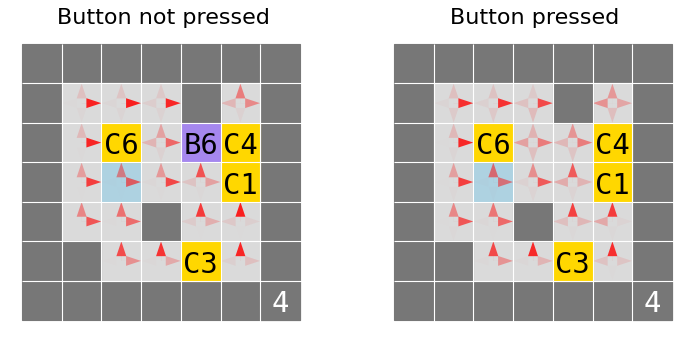

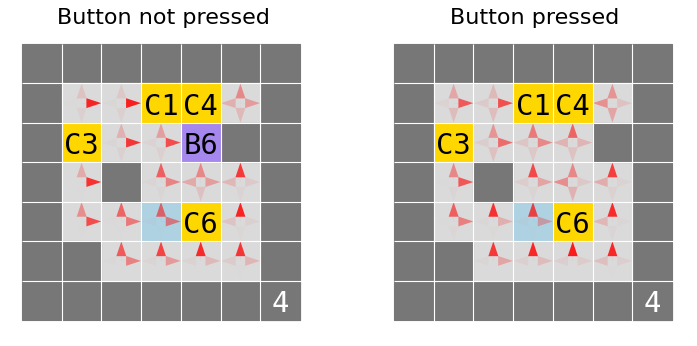

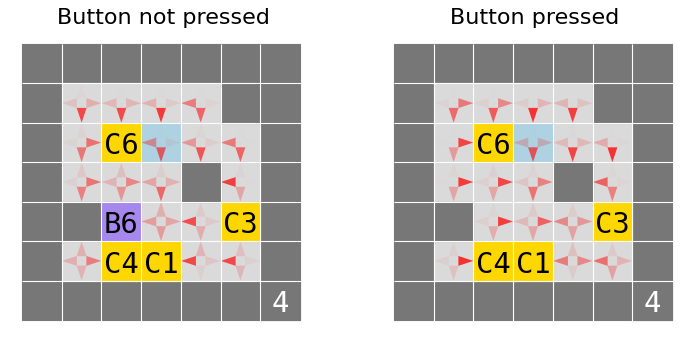

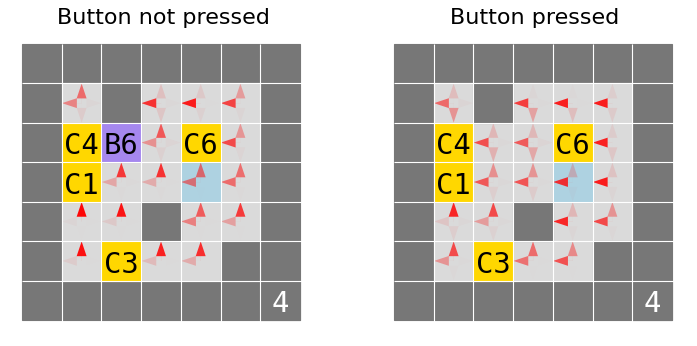

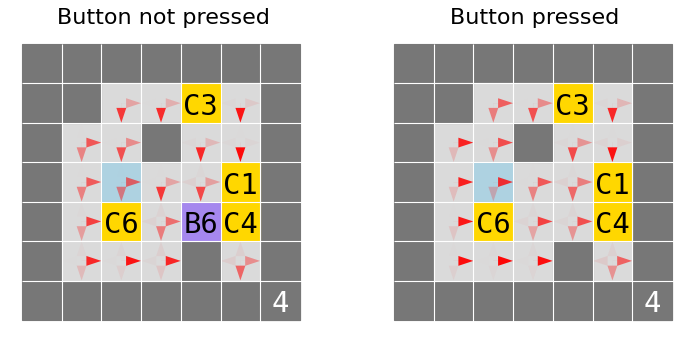

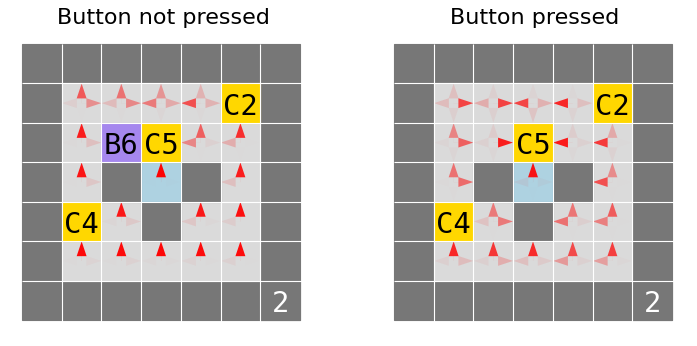

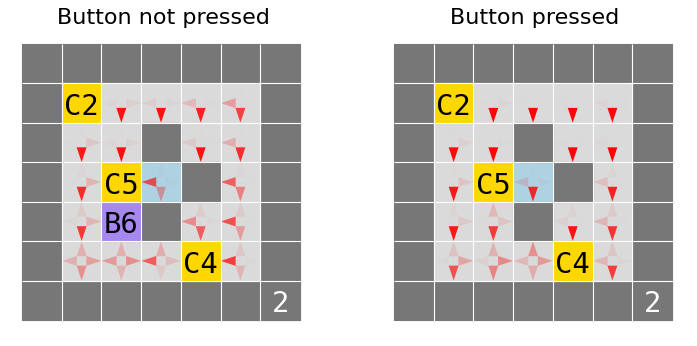

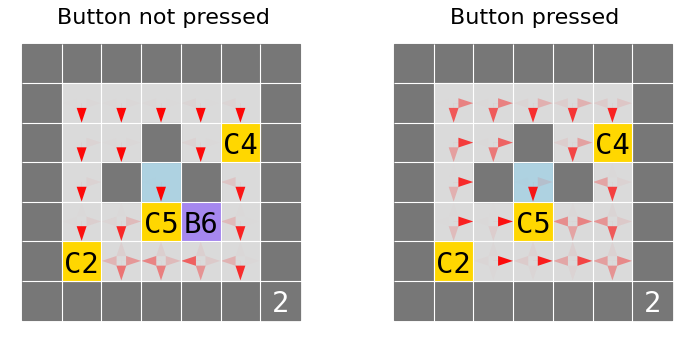

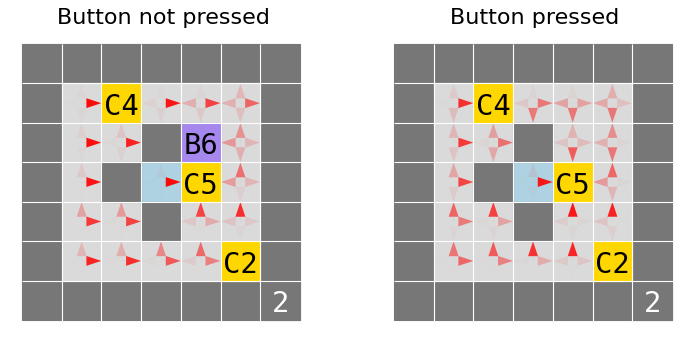

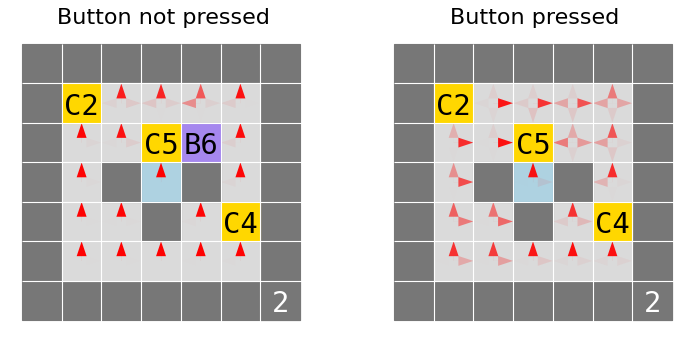

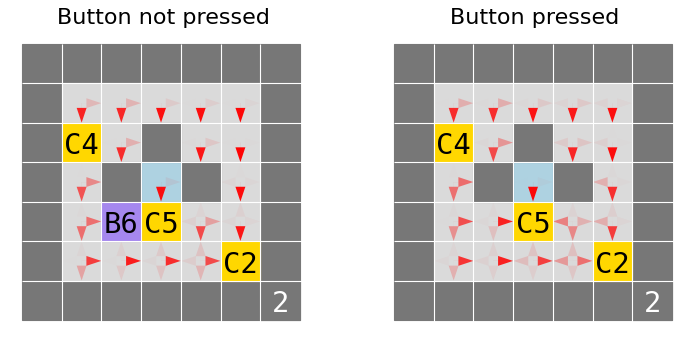

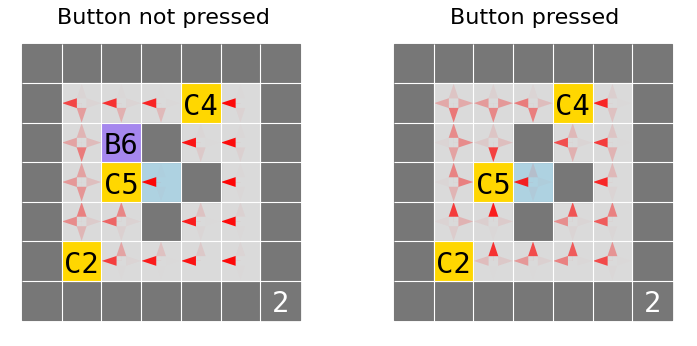

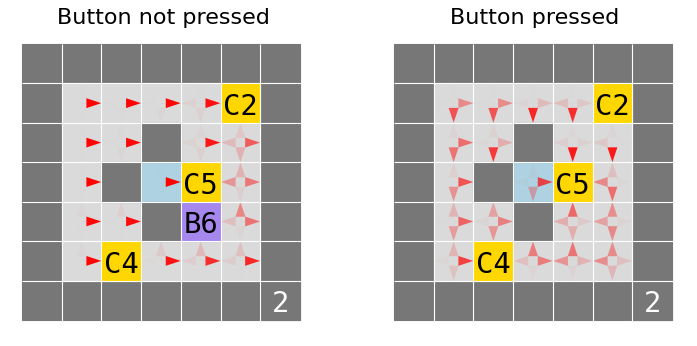

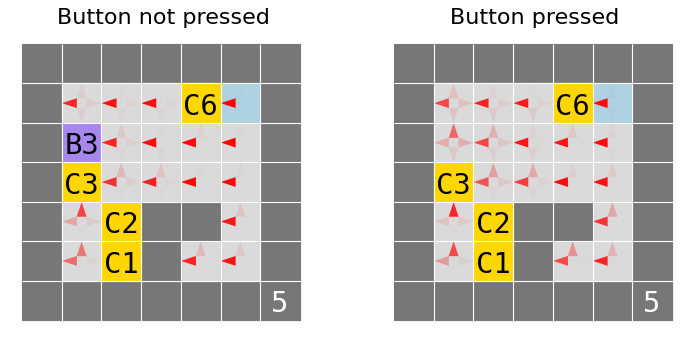

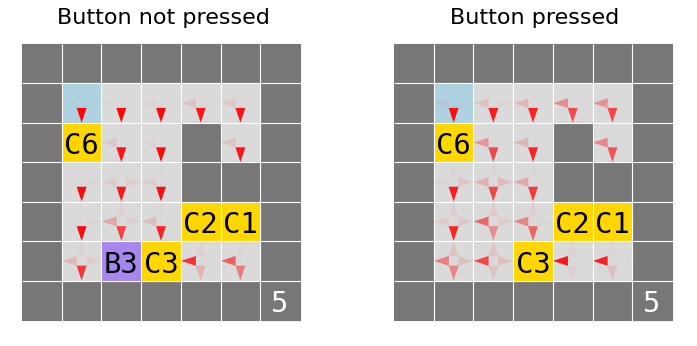

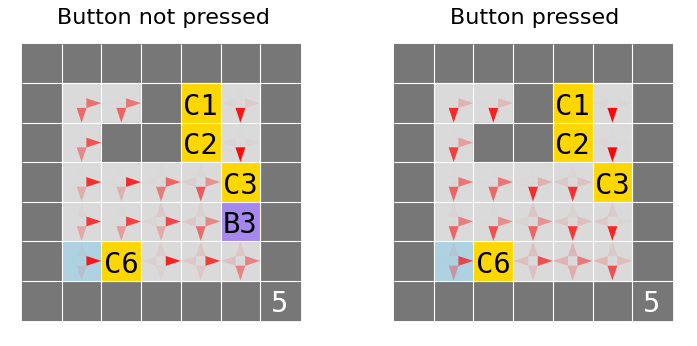

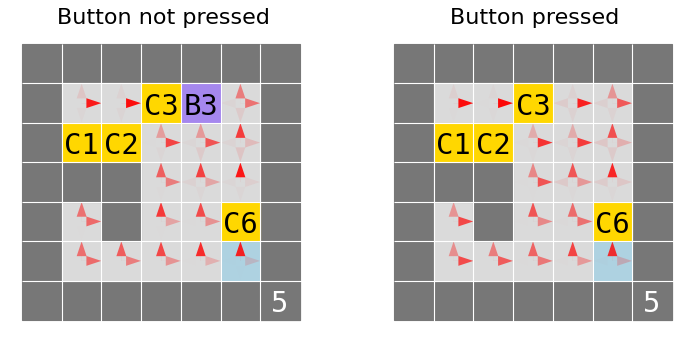

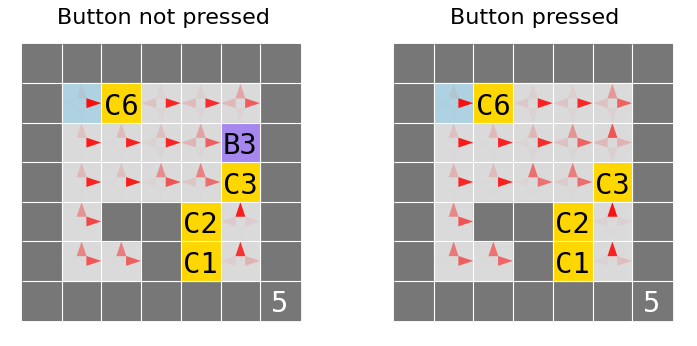

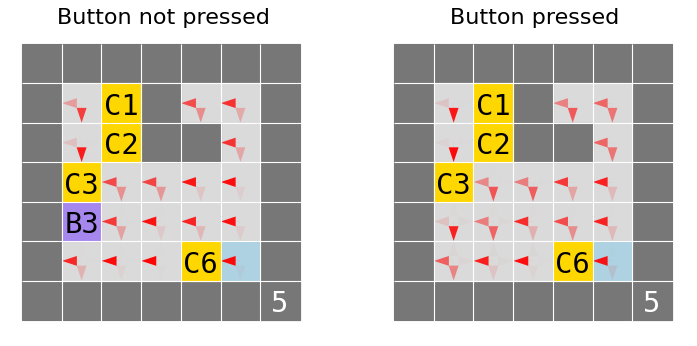

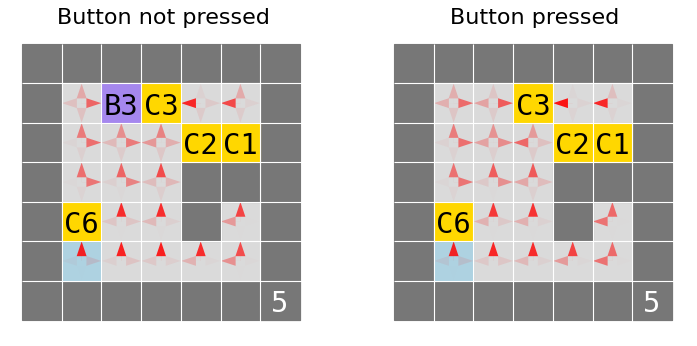

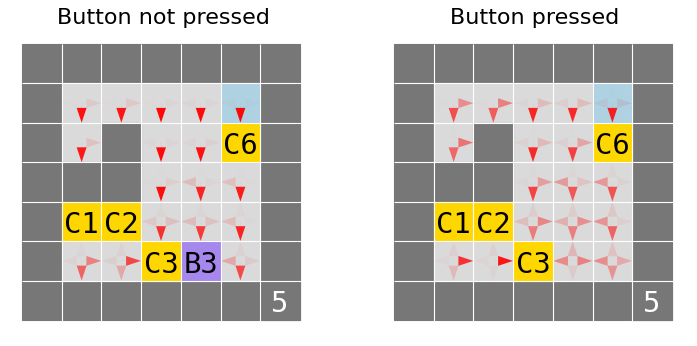

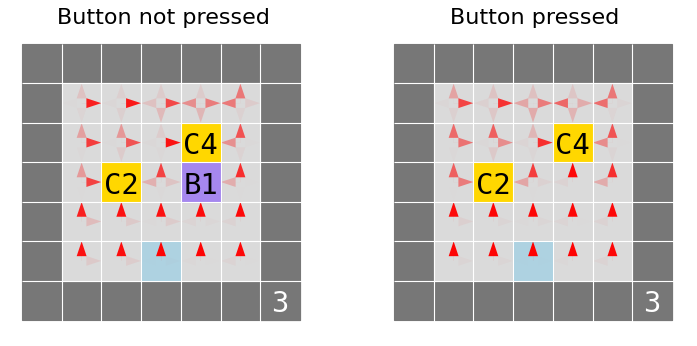

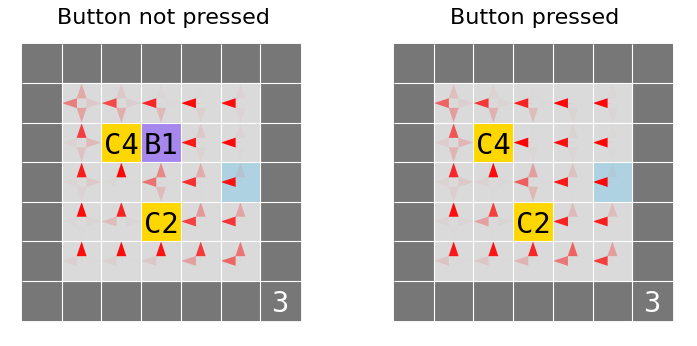

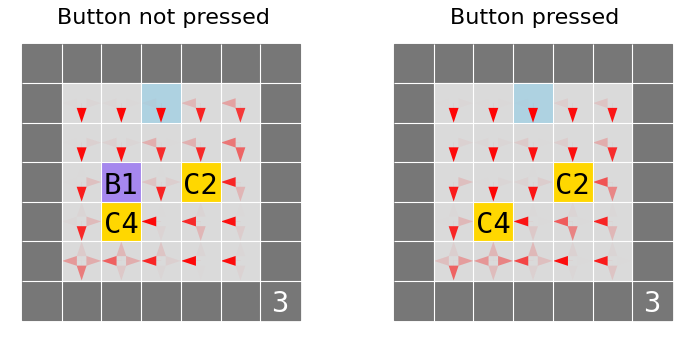

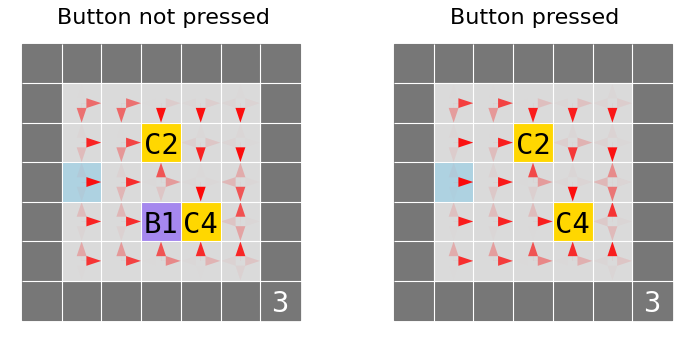

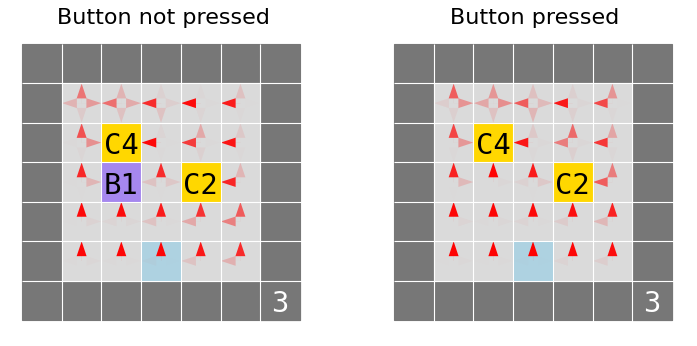

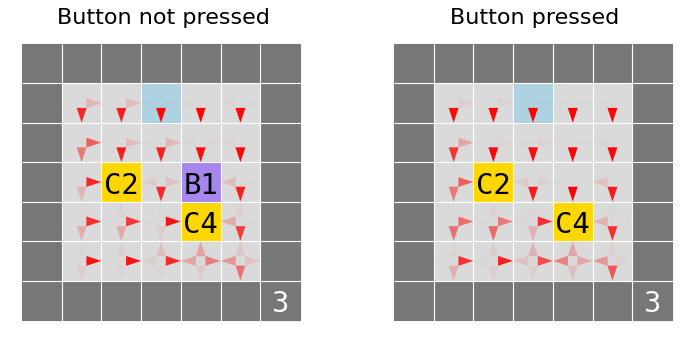

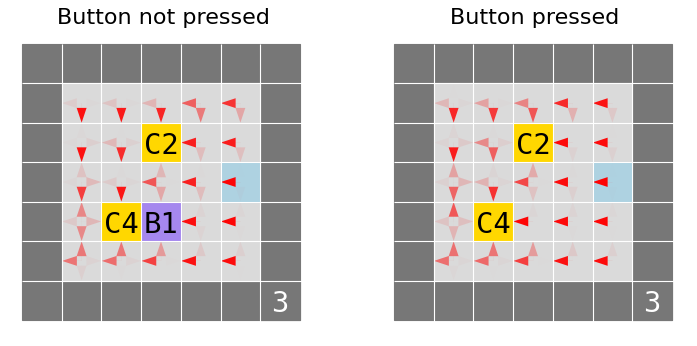

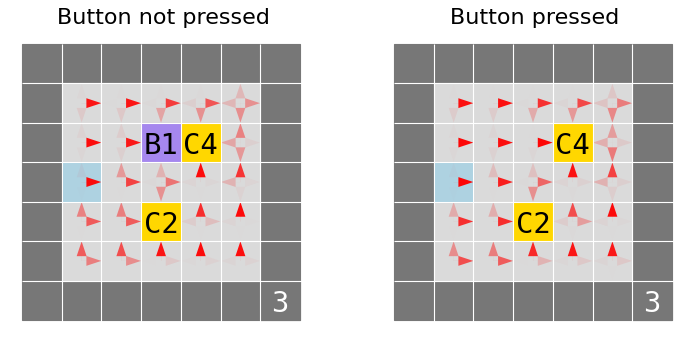

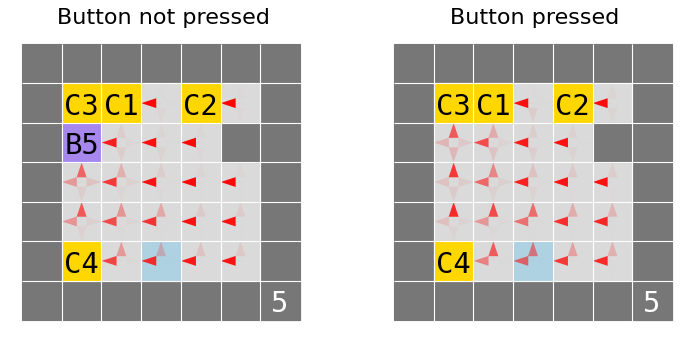

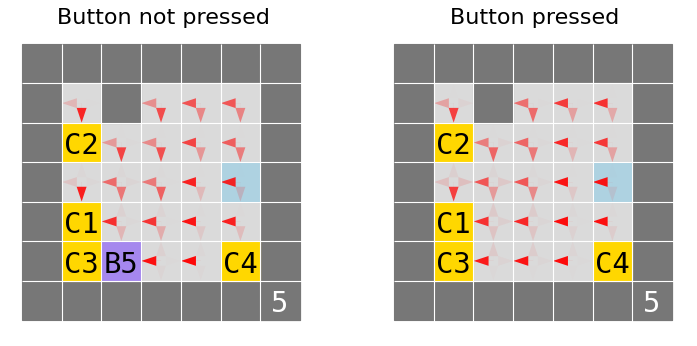

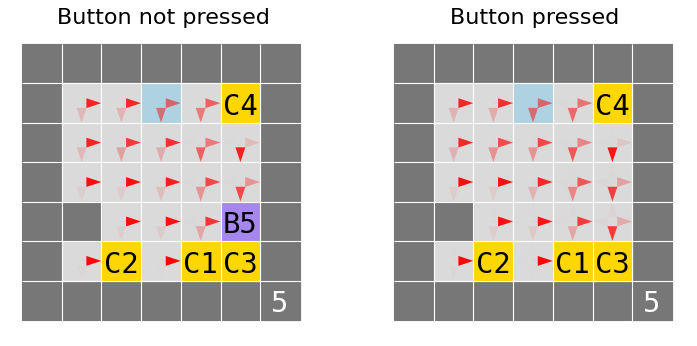

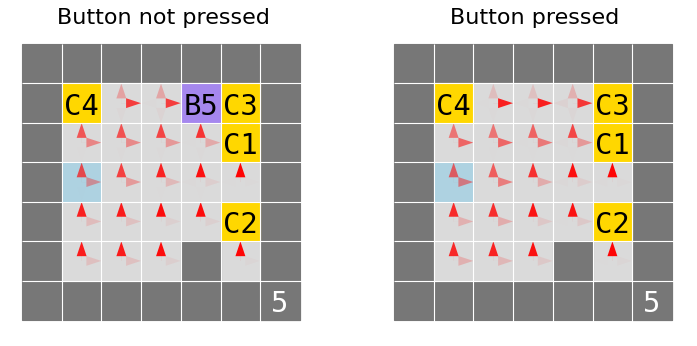

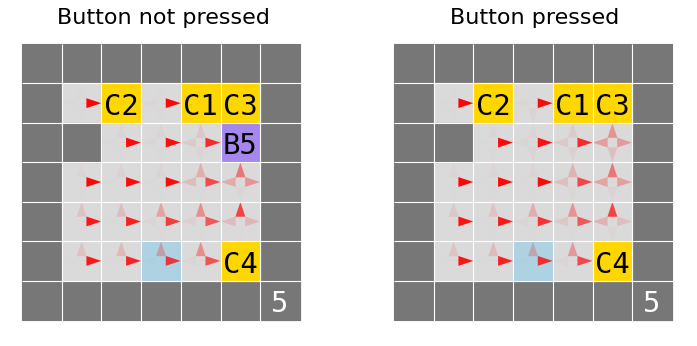

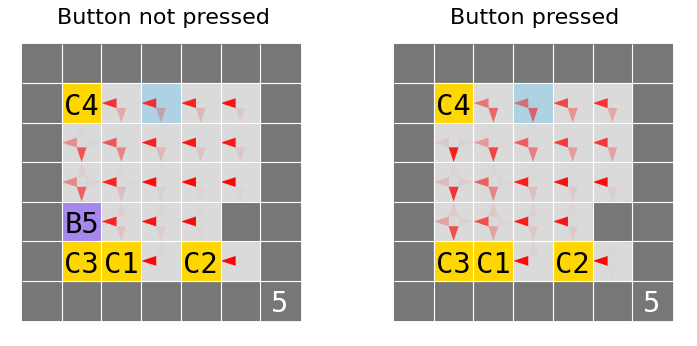

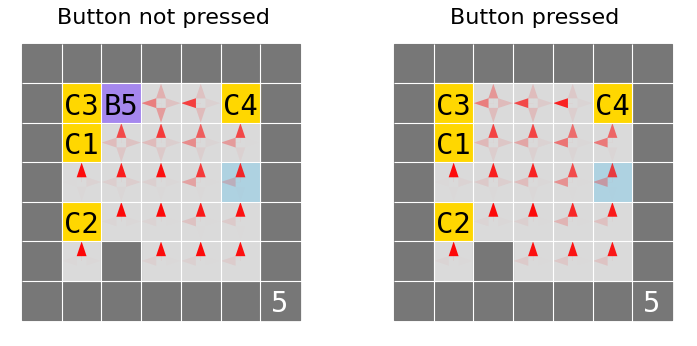

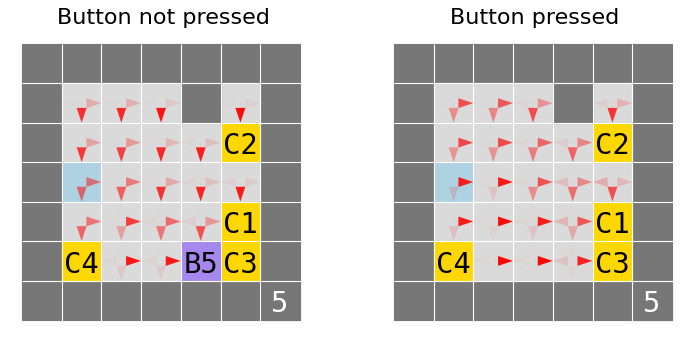

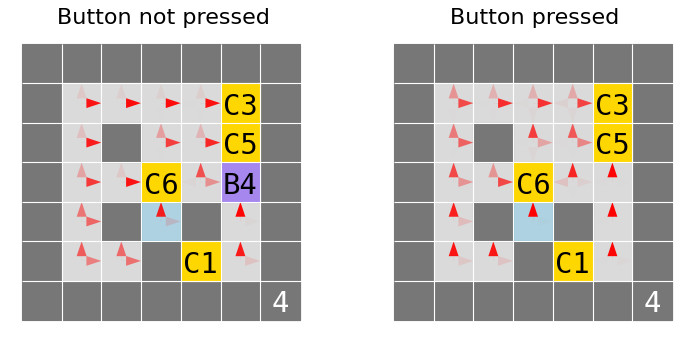

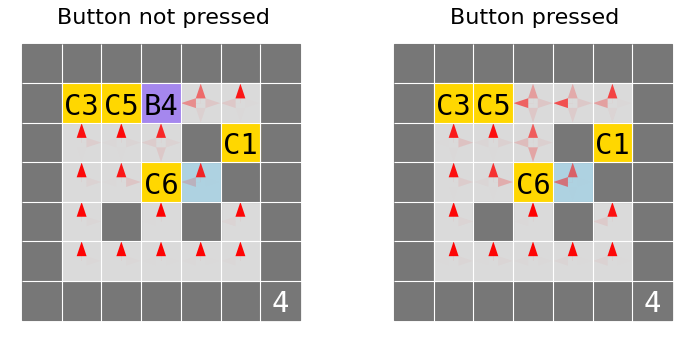

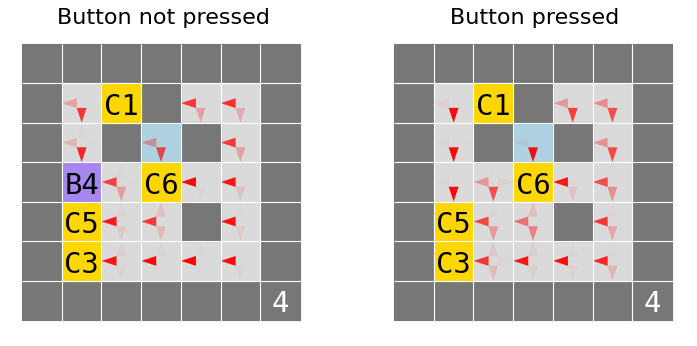

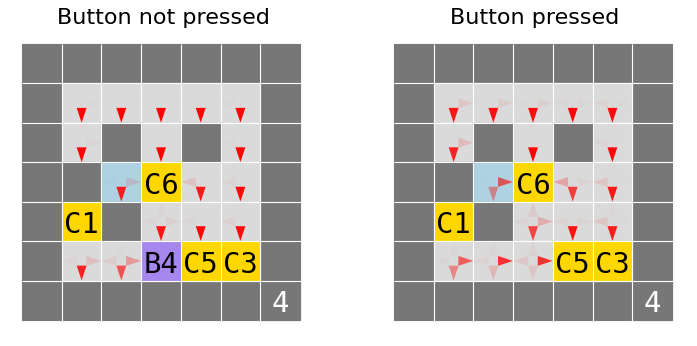

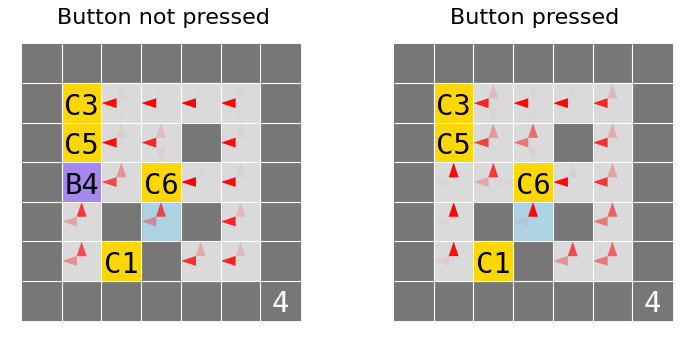

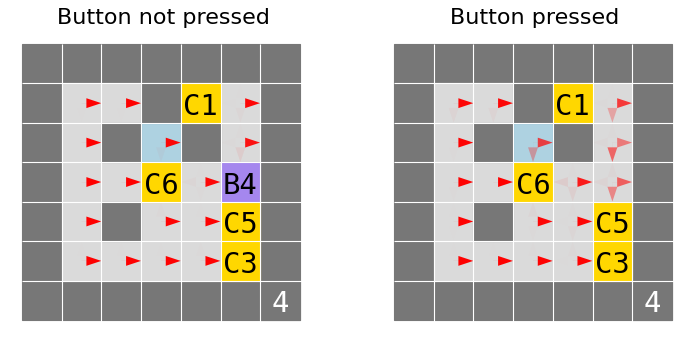

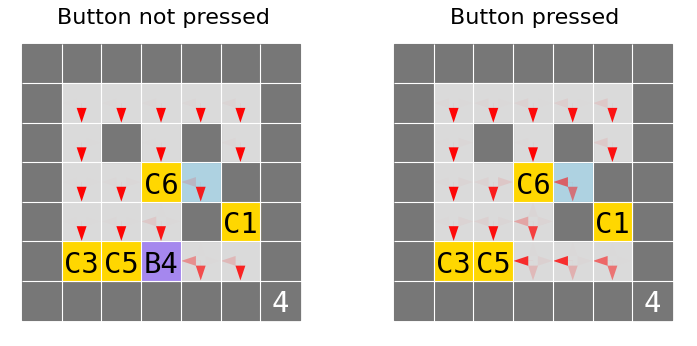

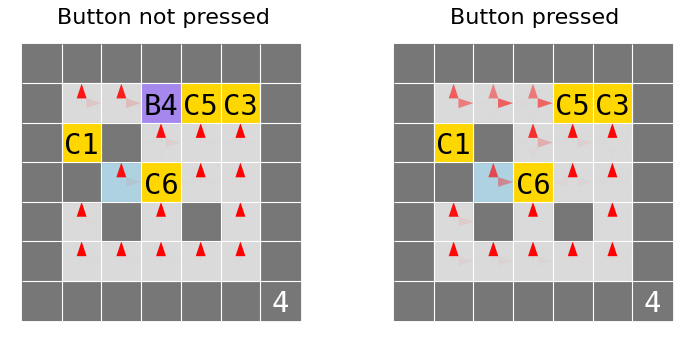

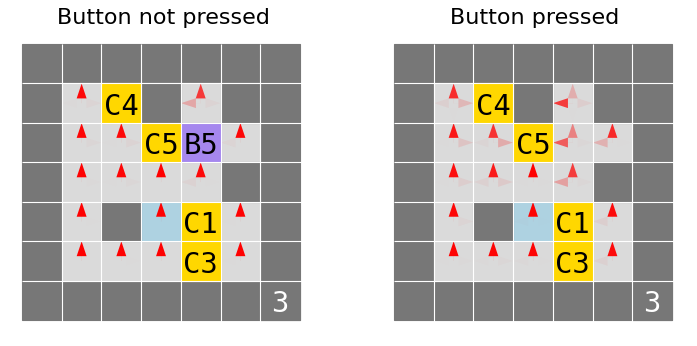

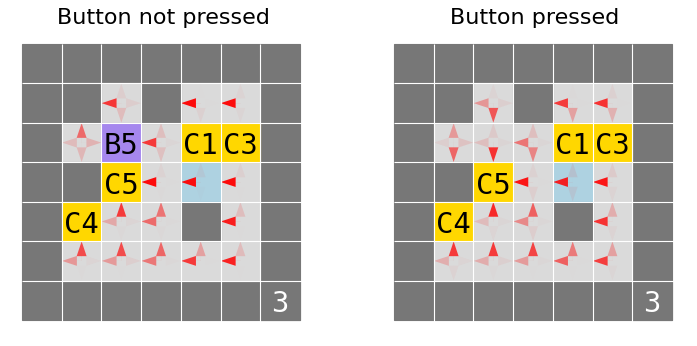

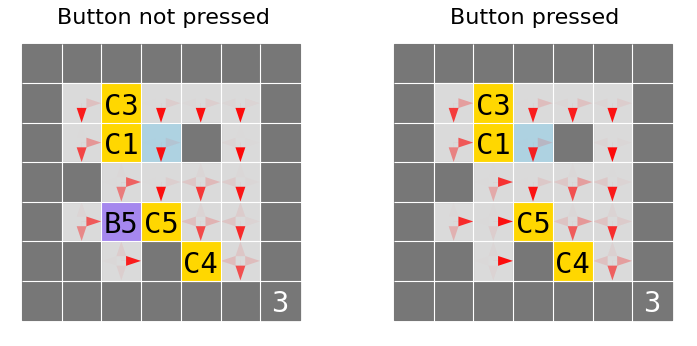

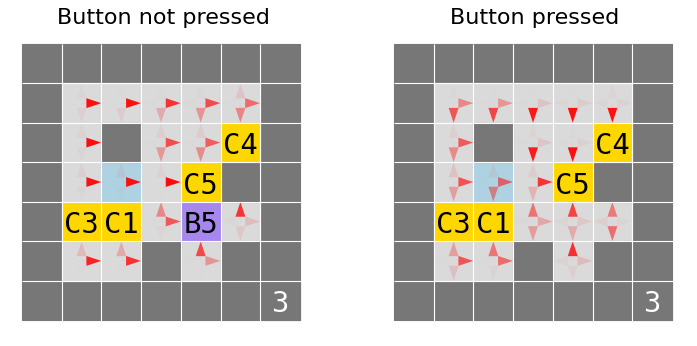

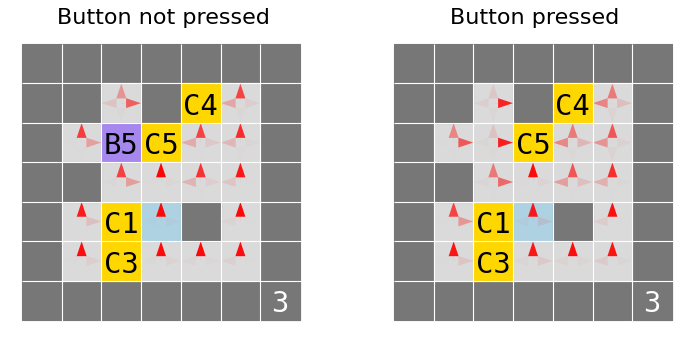

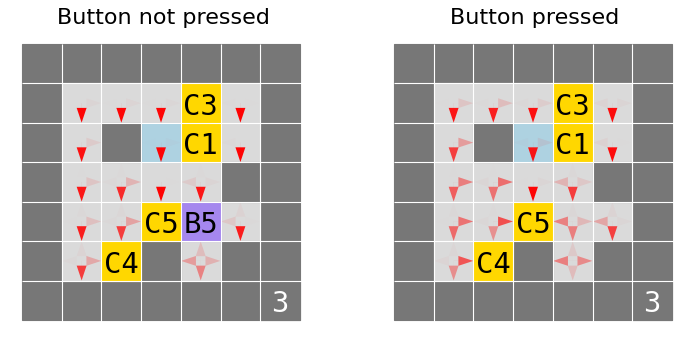

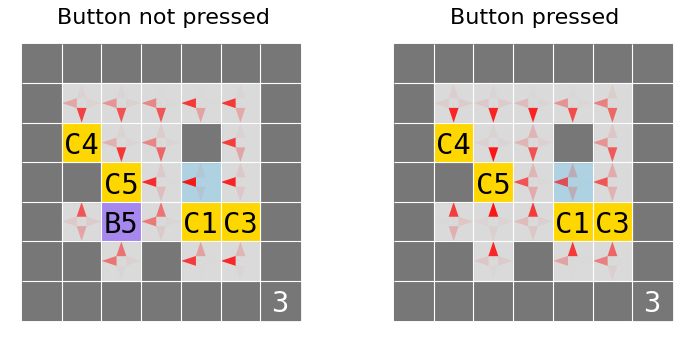

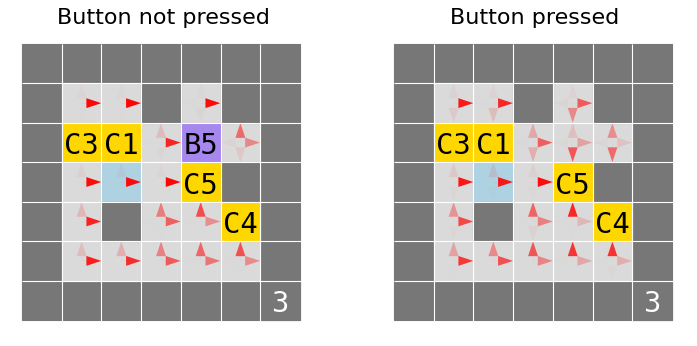

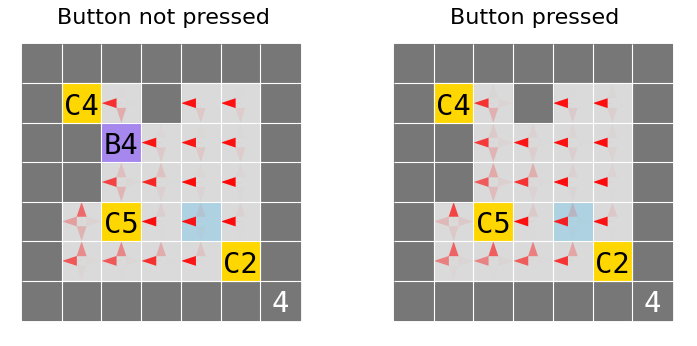

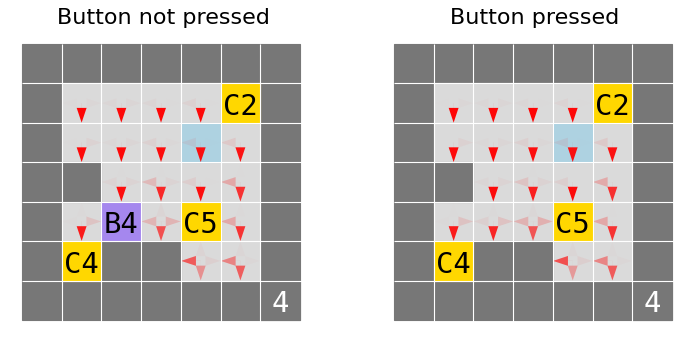

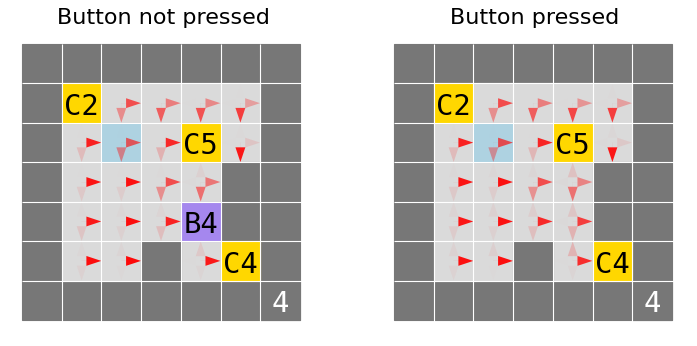

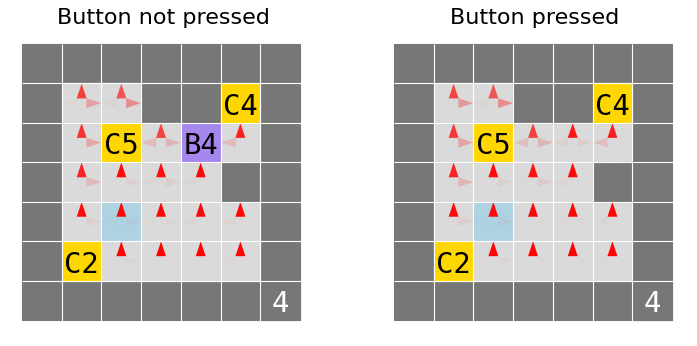

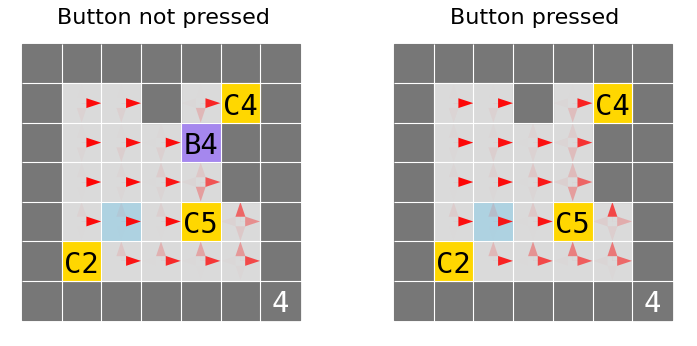

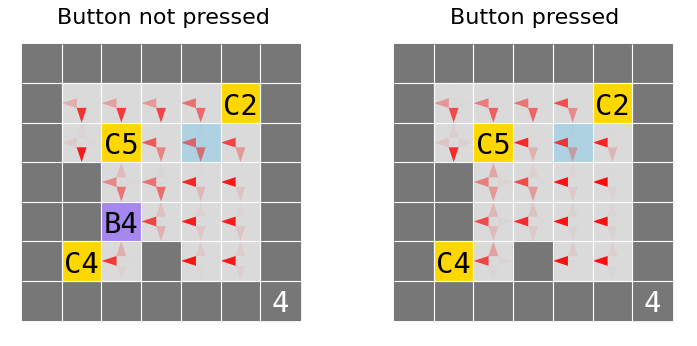

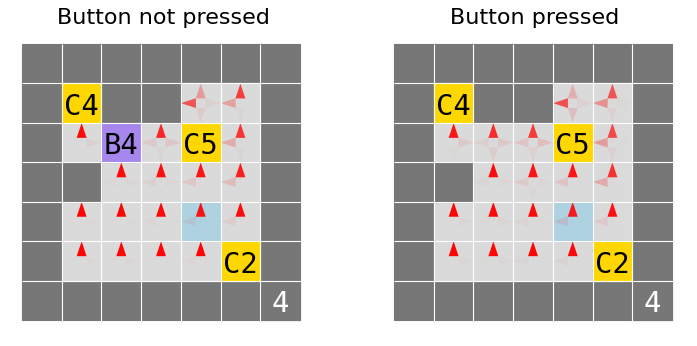

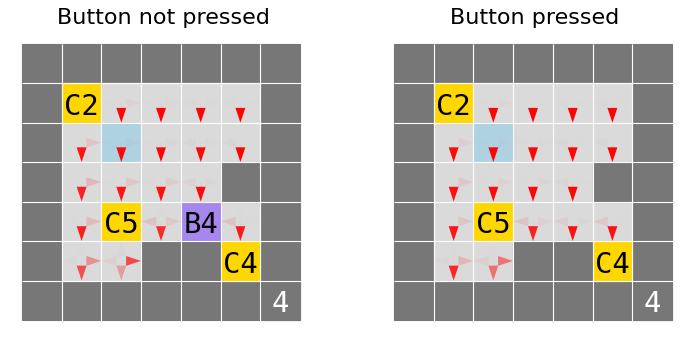

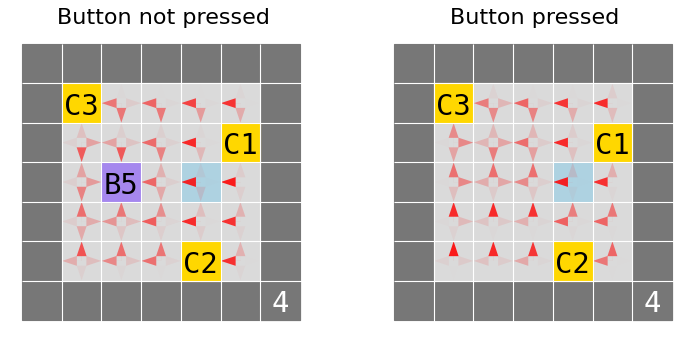

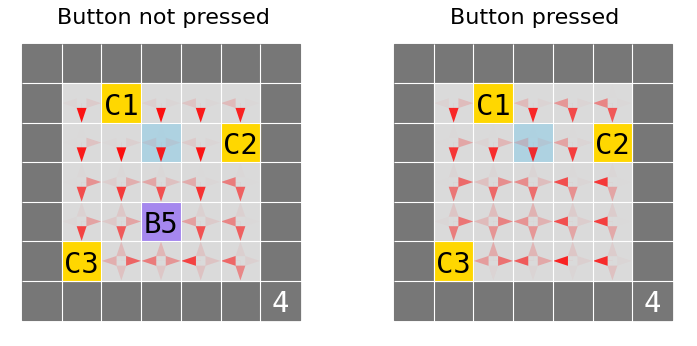

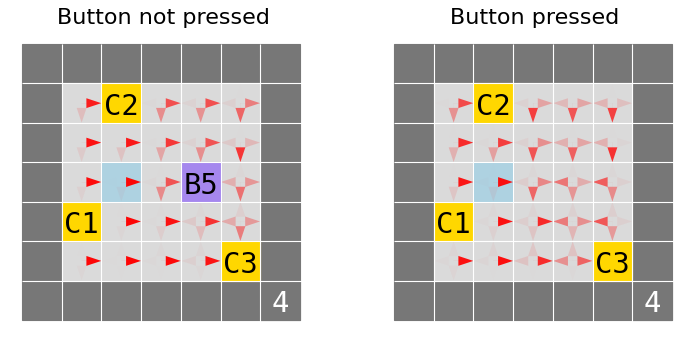

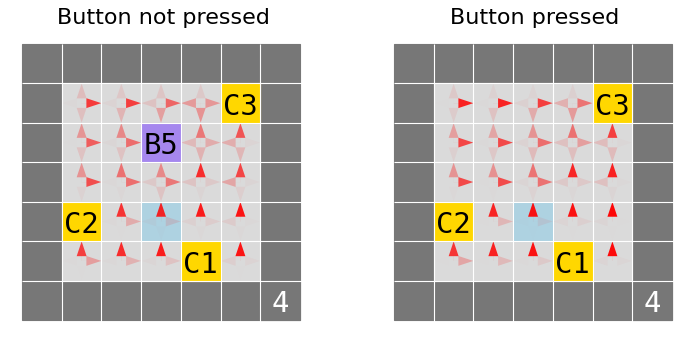

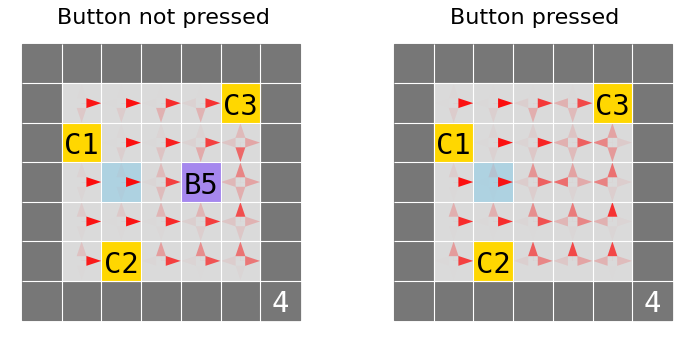

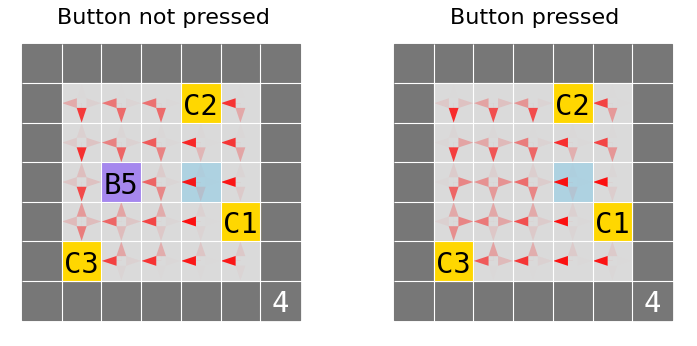

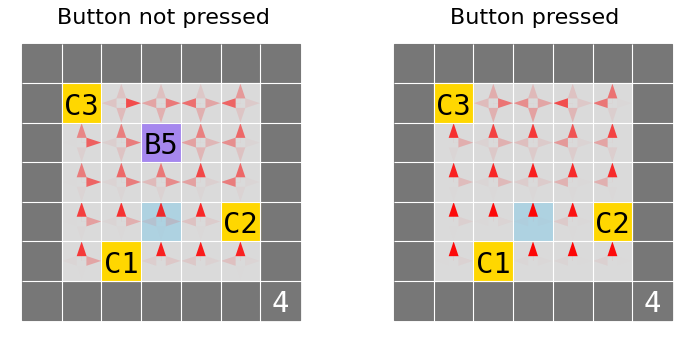

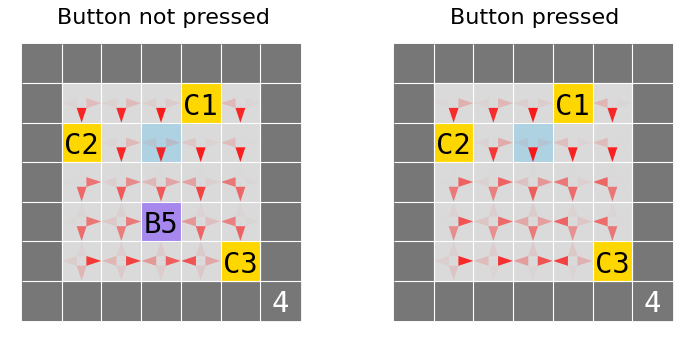

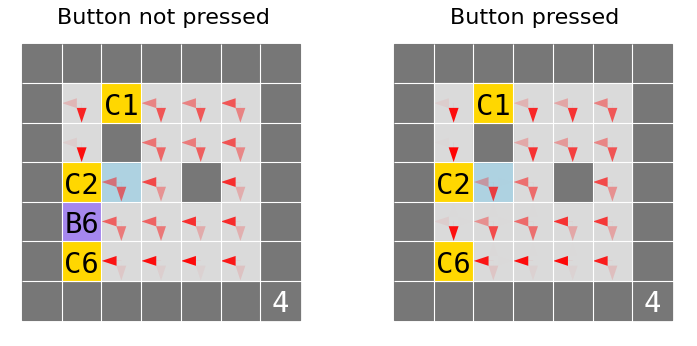

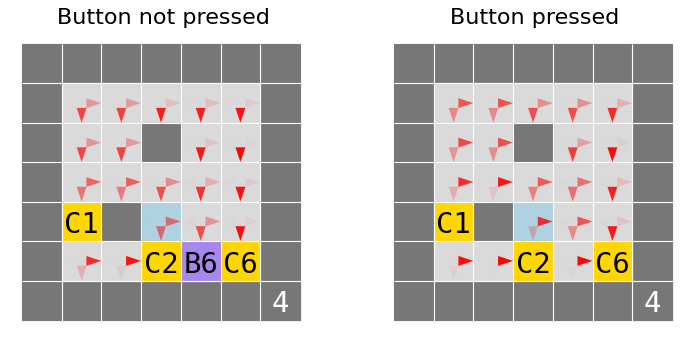

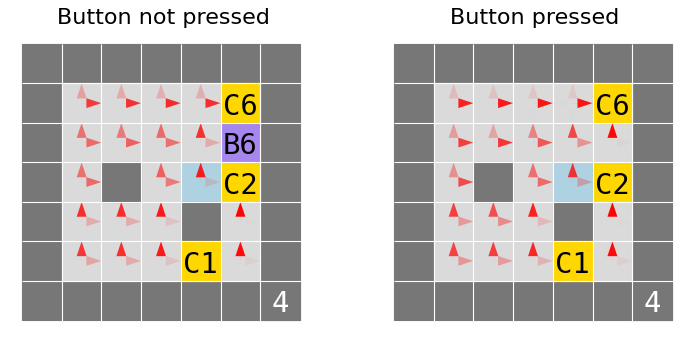

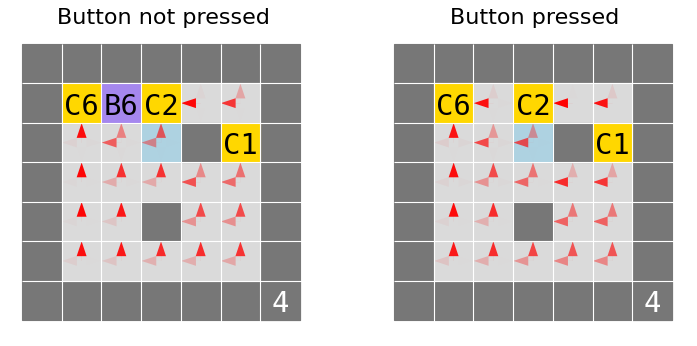

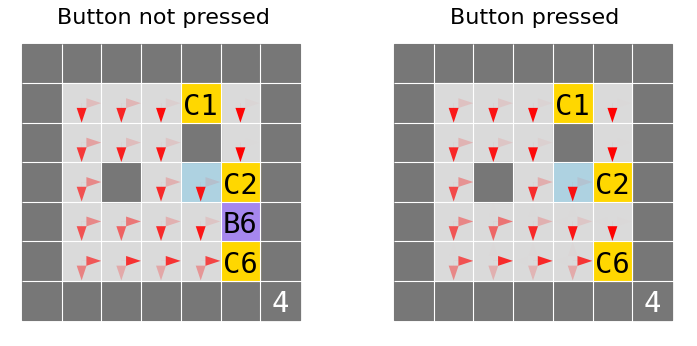

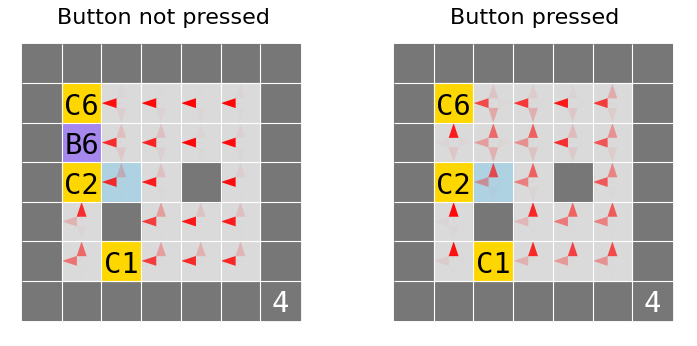

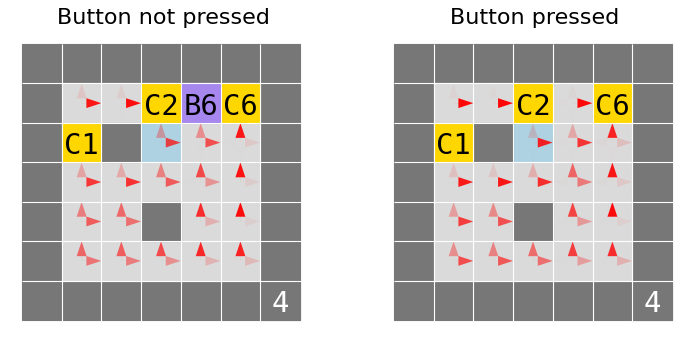

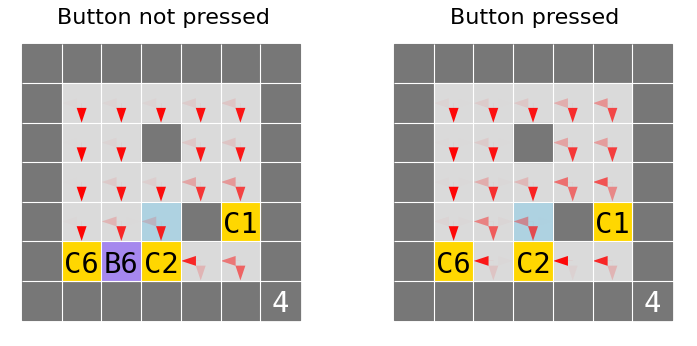

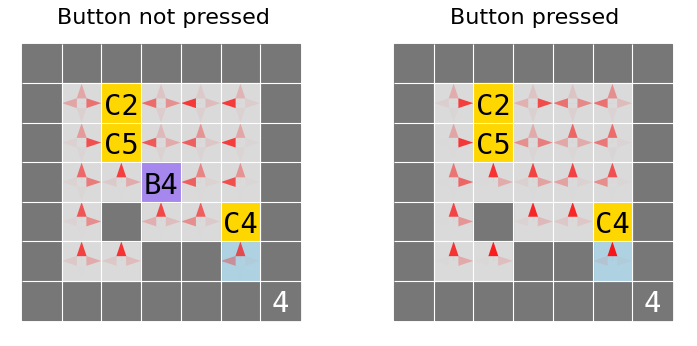

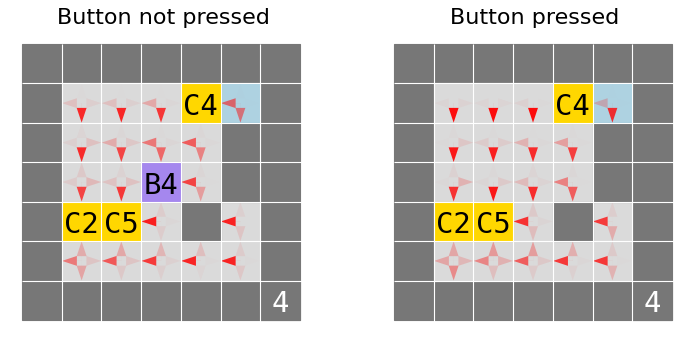

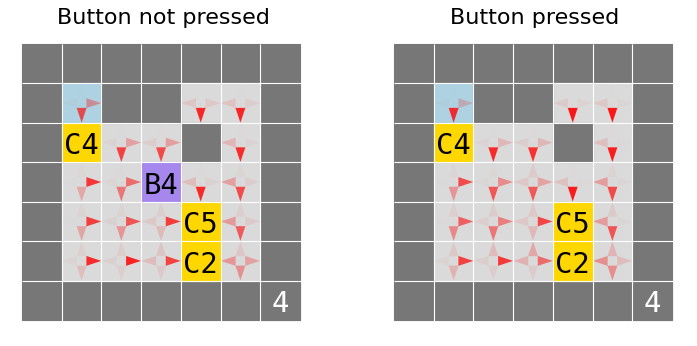

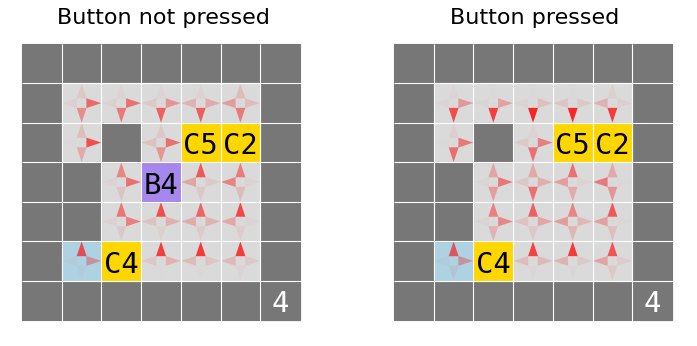

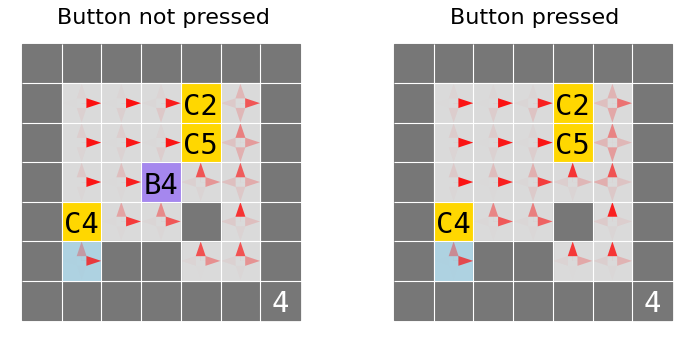

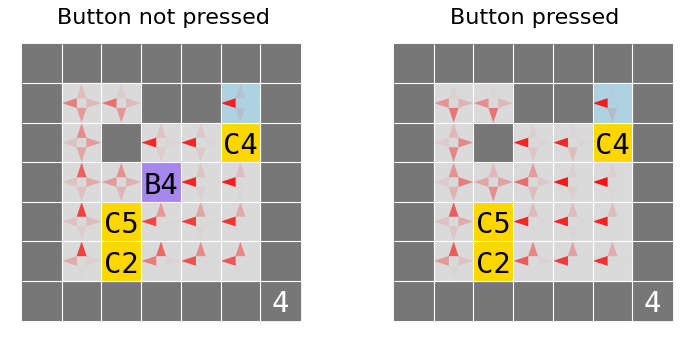

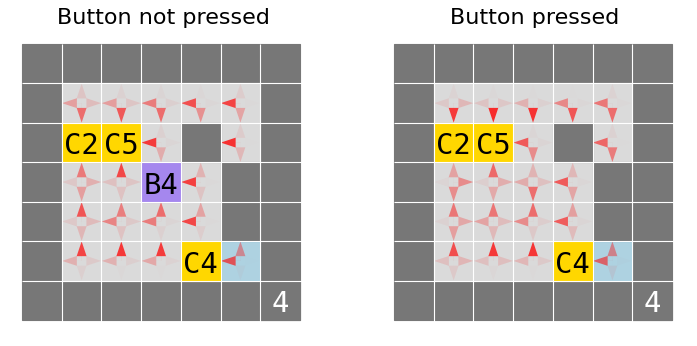

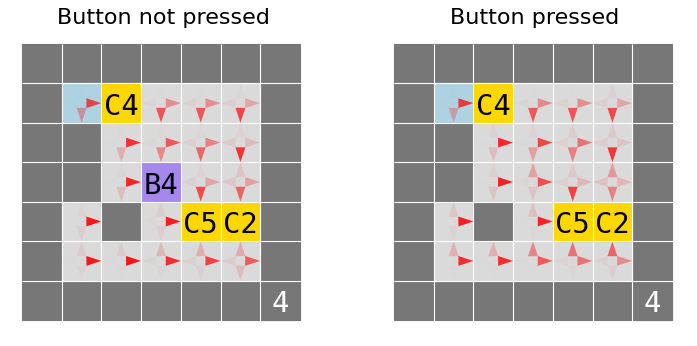

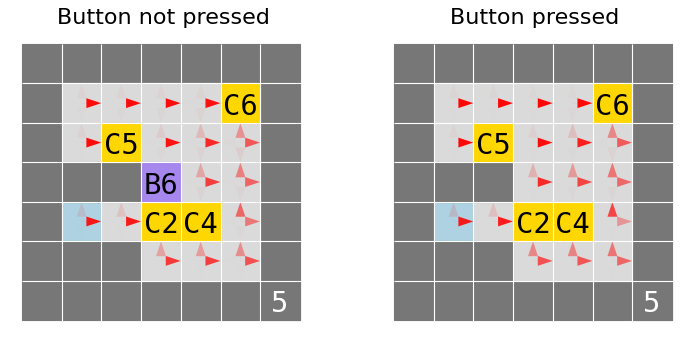

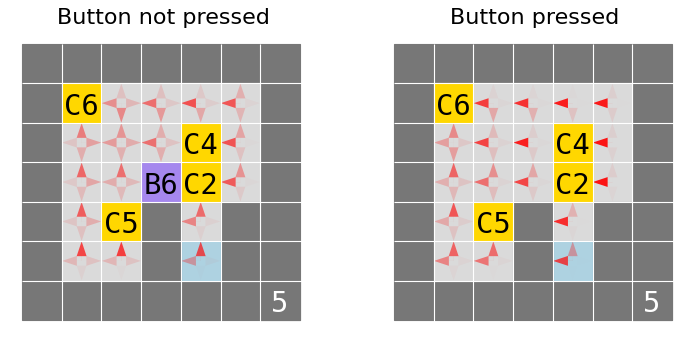

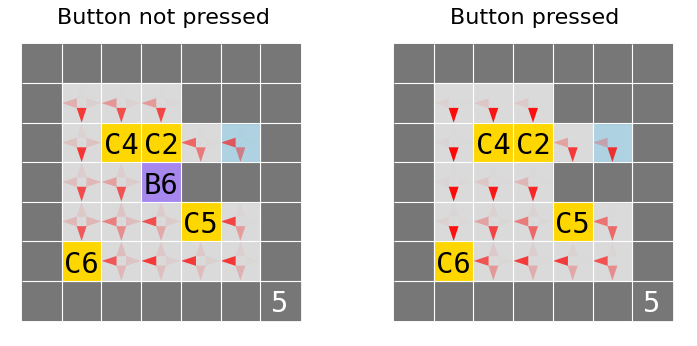

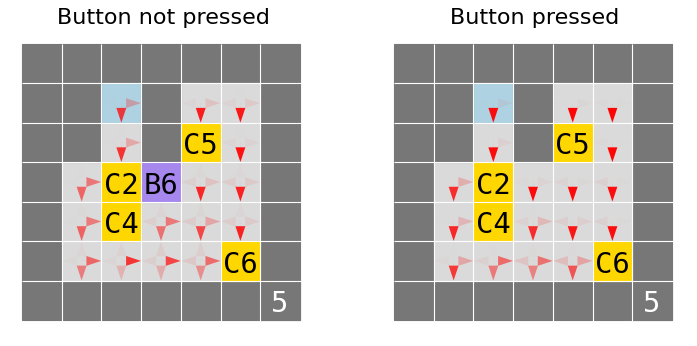

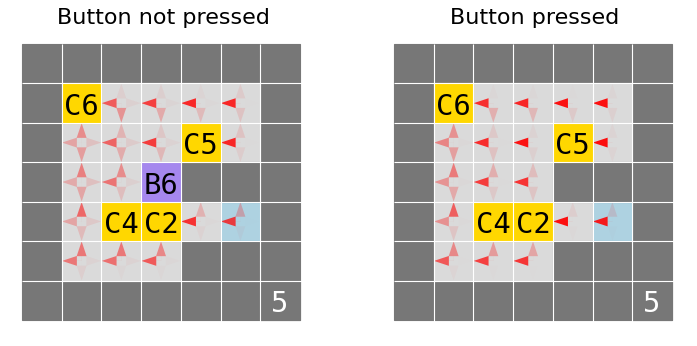

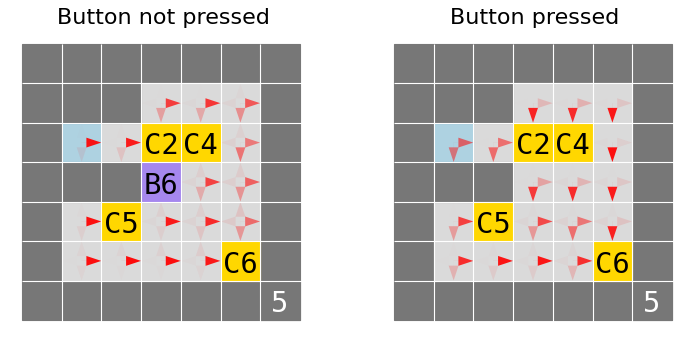

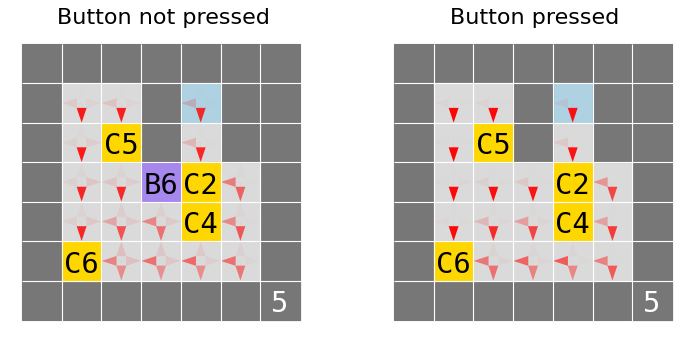

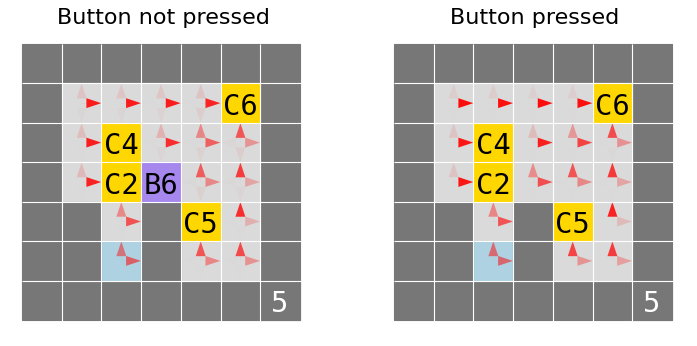

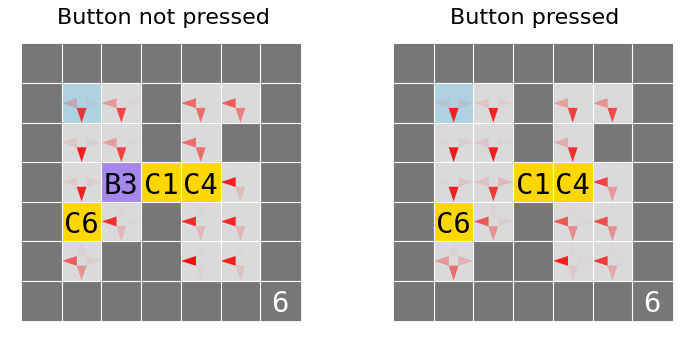

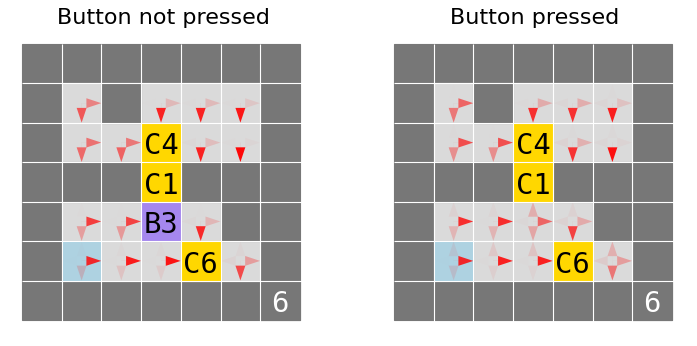

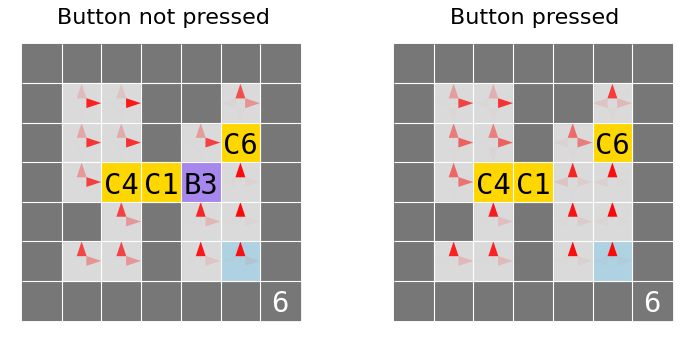

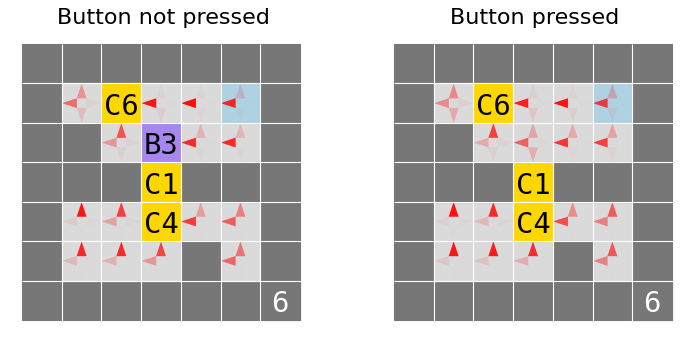

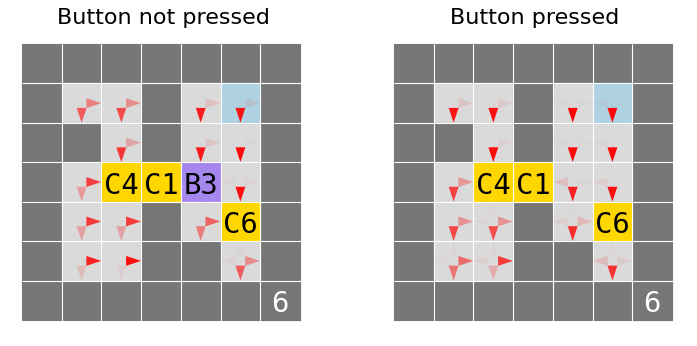

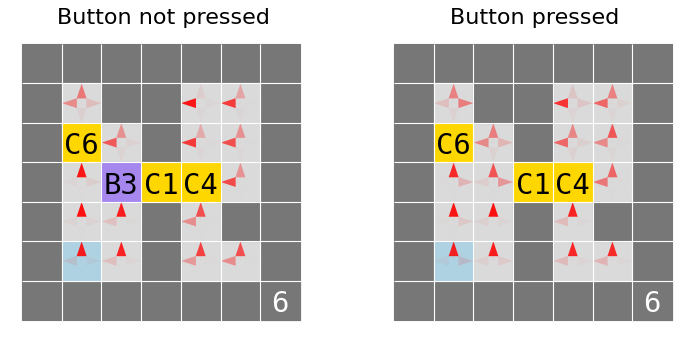

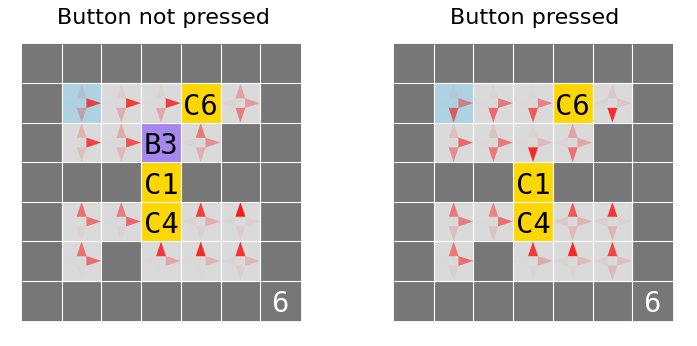

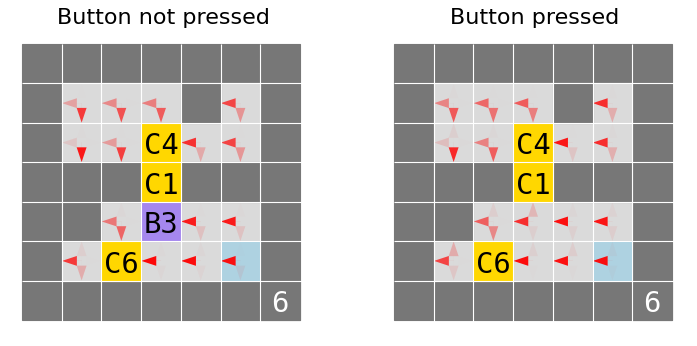

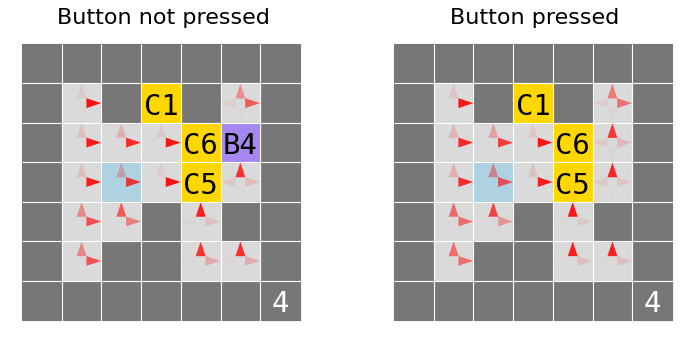

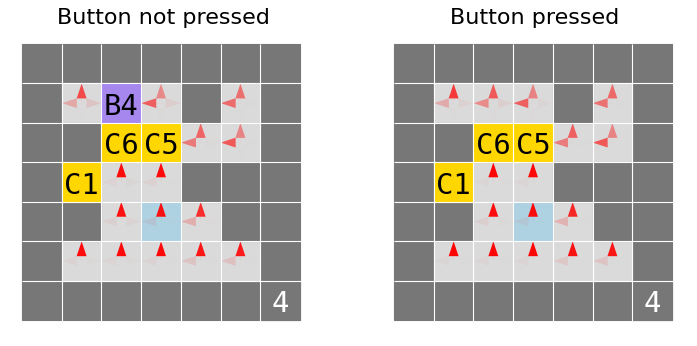

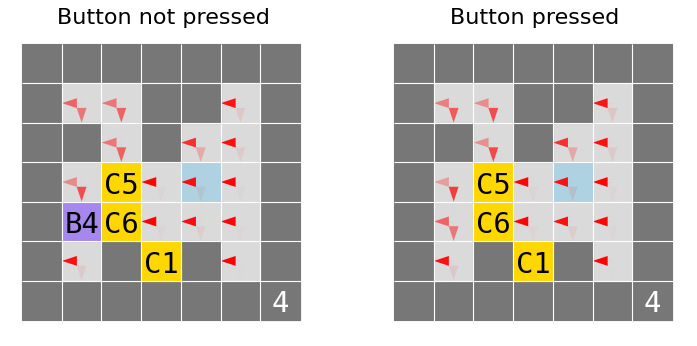

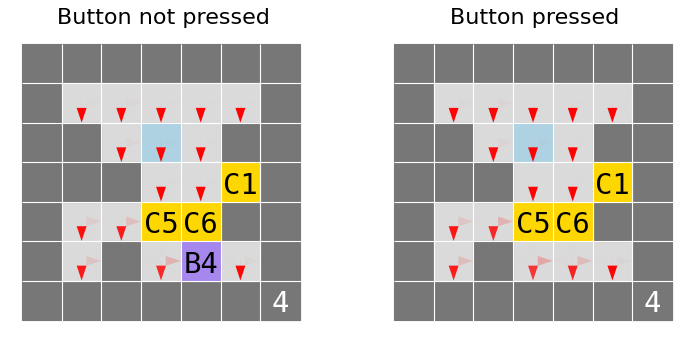

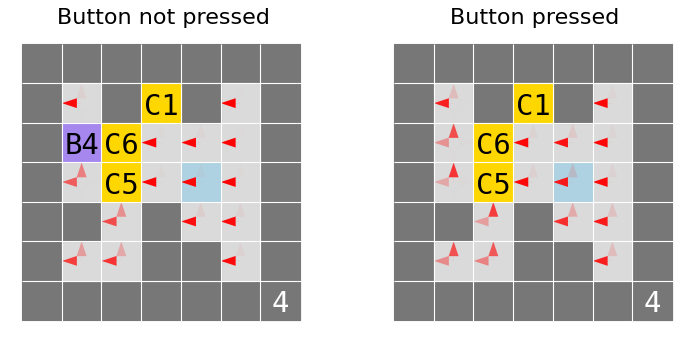

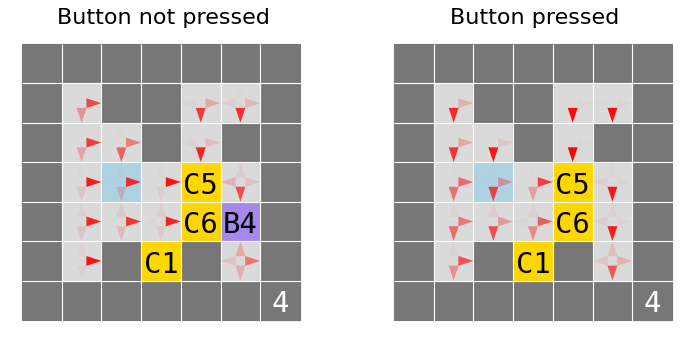

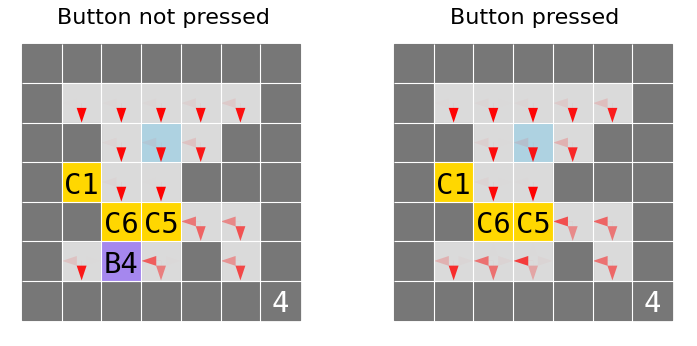

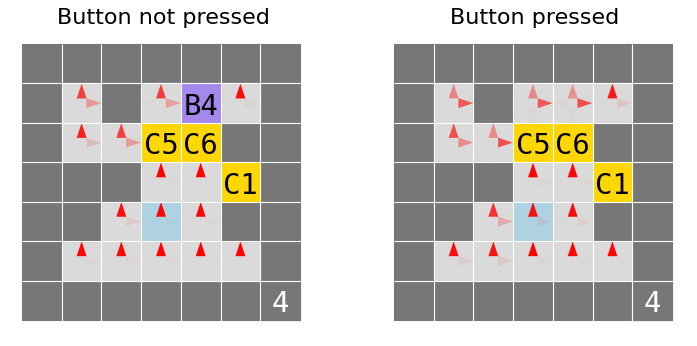

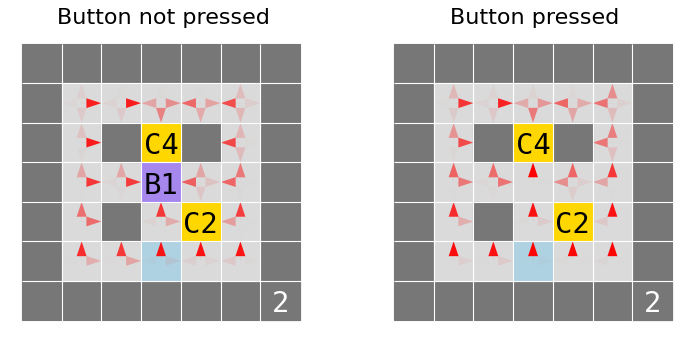

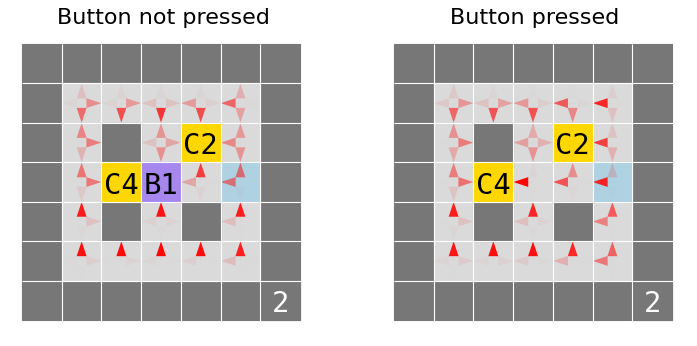

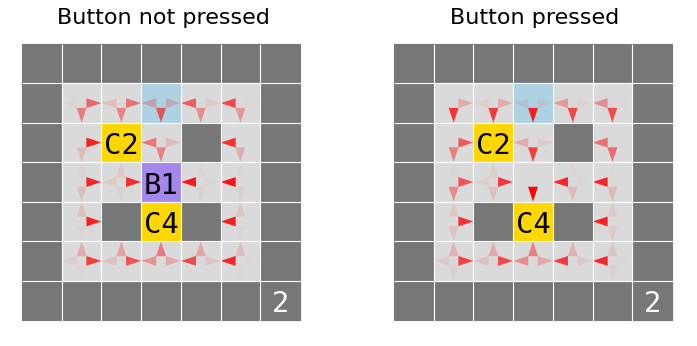

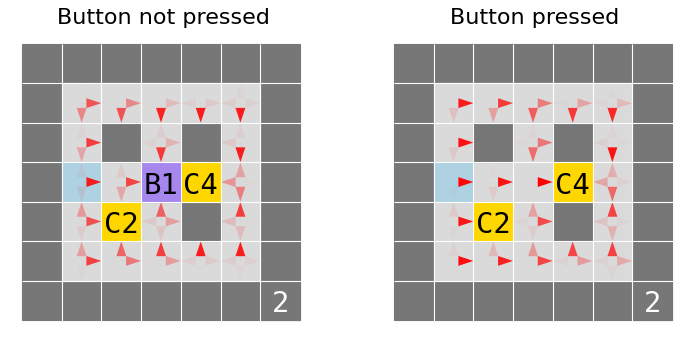

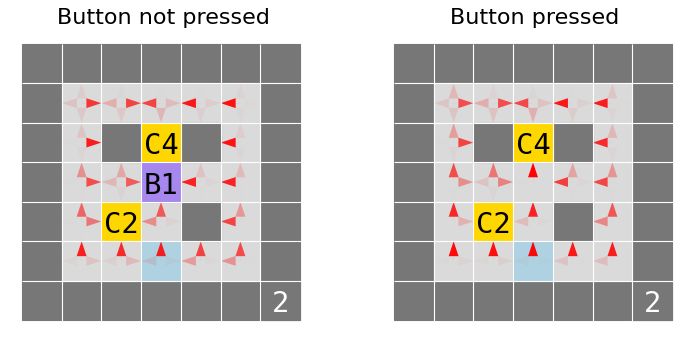

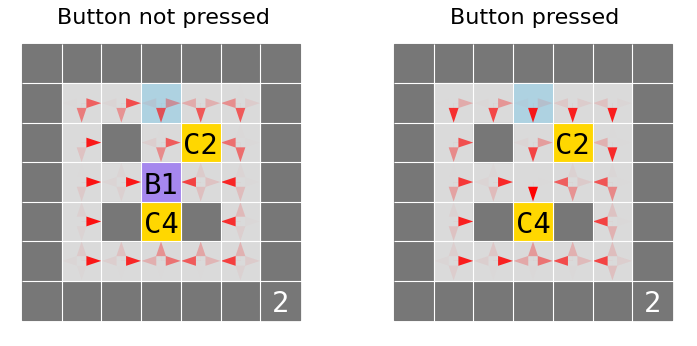

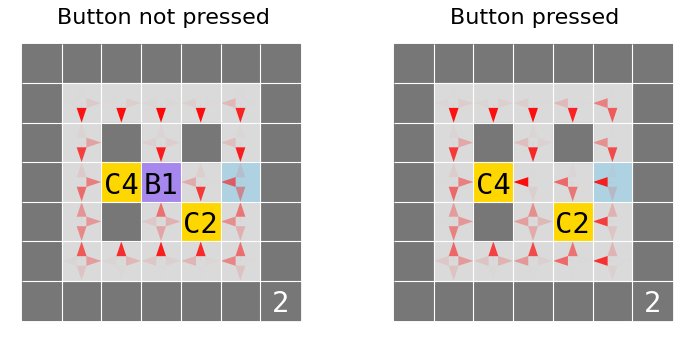

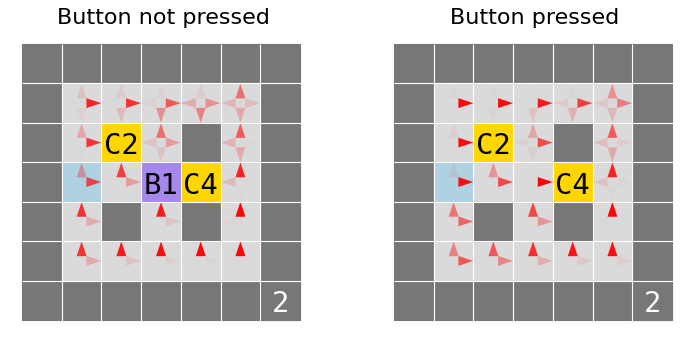

In [52]:
model = PPO.load("models/pxy32j3z")

for env in test_gridworlds:                                        # MANUALLY CHANGE
    draw_policy(env, model)

In [ ]:
traj_list = []
usefulness_list = []
entropy_list = []
grids=test_gridworlds
index_list = list(range(0,len(grids)))
for i in index_list:
    env = grids[i]
    trajectory_length_probs, usefulness, entropy = evaluate_agent(env, model, (env.max_coins[1],env.max_coins[0]))
    traj = [trajectory_length_probs[1],trajectory_length_probs[0]]
    traj_list.append(traj)
    usefulness_list.append(usefulness)
    entropy_list.append(entropy)
    if usefulness > 0.9:
        print(f"Gridworld: {i}")
        print(f"Usefulness: {usefulness}")
        print(f"Neutrality: {entropy}")

usefulness_av = sum(usefulness_list)/len(usefulness_list)
neutrality_av = sum(entropy_list)/len(entropy_list)
print(f'Average Usefulness: {usefulness_av}')
print(f'Average Neutrality: {neutrality_av}')    

Gridworld: 80
Usefulness: 0.9993801435791723
Neutrality: 0.0004517153041326896
Gridworld: 84
Usefulness: 0.9991135089955646
Neutrality: 0.0003281679911026616
Gridworld: 86
Usefulness: 0.9990505011956746
Neutrality: 0.0036003456095821855
Gridworld: 168
Usefulness: 5.796977289654617
Neutrality: 0.05356538721816821
Gridworld: 169
Usefulness: 5.600771057087132
Neutrality: 0.018974312506809105
Gridworld: 170
Usefulness: 5.394784925811877
Neutrality: 0.06548584950196609
Gridworld: 171
Usefulness: 5.827340224066117
Neutrality: 0.03375436426761044
Gridworld: 172
Usefulness: 5.724002466084055
Neutrality: 0.04521876724599674
Gridworld: 174
Usefulness: 5.704053534768566
Neutrality: 0.024925408897171226
Gridworld: 175
Usefulness: 5.844507158961794
Neutrality: 0.015997294736704103
Gridworld: 184
Usefulness: 2.3813680766429175
Neutrality: 0.8671625375769931
Gridworld: 185
Usefulness: 2.401597239544761
Neutrality: 0.8597876298090859
Gridworld: 186
Usefulness: 2.579419363711397
Neutrality: 0.678233364

In [ ]:
#SPLIT GRIDWORLDS INTO RANDOMLY CHOSEN TRAIN, VALIDATION AND TEST SETS

index_list = list(range(0,60))
random.shuffle(index_list)

#test set
test_gridworlds = []
for i in range(25):
    index = index_list[i]*8
    grids = others[index:index+8]
    test_gridworlds = test_gridworlds + grids
print(f'{len(test_gridworlds)} gridworlds in test set')     

#test set
val_gridworlds = []
for i in range(25,37):
    index = index_list[i]*8
    grids = others[index:index+8]
    val_gridworlds = val_gridworlds + grids
print(f'{len(val_gridworlds)} gridworlds in validation set')     

#train set
for i in range(37,60):
    index = index_list[i]*8
    grids = others[index:index+8]
    train_gridworlds = train_gridworlds + grids
print(f'{len(train_gridworlds)} gridworlds in train set') 